#Creating Directories and Unzipping Files

In [ ]:
!mkdir dataset


In [ ]:
!unzip "/content/drive/MyDrive/Praktikum/train_phase2" -d "/content/content_data/"

#Installing Requirements

In [ ]:
!pip install --upgrade pip

In [1]:
# Install the required packages
!pip install numpy pandas pydicom scikit-image imageio pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


#Prep of the Folder

ZIPS

In [ ]:
# import zipfile
# import os
# from google.colab import files
# from typing import List

# def combine_and_extract_zip_files(zip_files: List[str], extract_to: str) -> List[str]:
#     """
#     Upload and extract multiple ZIP files into a single directory.
#     Collect all DICOM file paths from the extracted directories.

#     Parameters:
#     - zip_files: List of ZIP file paths to be extracted.
#     - extract_to: Directory where the ZIP files will be extracted.

#     Returns:
#     - List of all DICOM file paths.
#     """
#     all_dicom_files = []

#     # Extract each ZIP file
#     for zip_file in zip_files:
#         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#             zip_ref.extractall(extract_to)

#     # Collect all DICOM files from the extracted directories
#     for subdir, _, files in os.walk(extract_to):
#         for file in files:
#             if file.lower().endswith('.dcm'):
#                 all_dicom_files.append(os.path.join(subdir, file))

#     return all_dicom_files

# # Upload the two ZIP files
# uploaded = files.upload()

# # Define the directory to extract the ZIP files to
# extract_to = '/content/Breast-Cancer-Screening-DBT'

# # Get the list of uploaded ZIP file paths
# zip_file_paths = list(uploaded.keys())

# # Combine and extract the ZIP files, and collect all DICOM file paths
# dicom_files = combine_and_extract_zip_files(zip_file_paths, extract_to)

# # Print the number of DICOM files found
# print(f"Found {len(dicom_files)} DICOM files.")


1 ZIP

In [ ]:
# from google.colab import files
# import zipfile
# import os

# # Upload ZIP file
# uploaded = files.upload()

# # Extract ZIP file
# for filename in uploaded.keys():
#     with zipfile.ZipFile(filename, 'r') as zip_ref:
#         zip_ref.extractall('/content/Breast-Cancer-Screening-DBT')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import os

def collect_dicom_files(root_dir: str) -> List[str]:
    """Collect all DICOM file paths from the directory structure."""
    dicom_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.dcm'):
                dicom_files.append(os.path.join(subdir, file))
    return dicom_files

# Collect all DICOM file paths
dicom_files = collect_dicom_files('/content/Breast-Cancer-Screening-DBT')
print(f"Found {len(dicom_files)} DICOM files.")


#Functions

In [ ]:
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
import numpy as np
import pandas as pd
import pydicom as dicom
from skimage.exposure import rescale_intensity
import imageio

def dcmread_image(fp: Union[str, os.PathLike[AnyStr], BinaryIO], view: str, index: Optional[np.uint] = None) -> np.ndarray:
    """Read pixel array from DBT DICOM file."""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")  # Use pylibjpeg for decompression
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])

    if index is not None:
        pixel_array = pixel_array[index]

    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))

    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(pixel_array, in_range=(low, high), out_range="dtype")

    return pixel_array

def read_boxes(boxes_fp: str, filepaths_fp: str) -> pd.DataFrame:
    """Read pandas DataFrame with bounding boxes joined with file paths."""
    df_boxes = pd.read_csv(boxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ("PatientID", "StudyUID", "View")
        if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in bounding boxes columns {df_boxes.columns}")

    if not all([key in df_filepaths.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}")

    return pd.merge(df_boxes, df_filepaths, on=primary_key)

def draw_box(image: np.ndarray, x: int, y: int, width: int, height: int, color: Optional[Union[int, tuple]] = None, lw=4) -> np.ndarray:
    """Draw bounding box on the image."""
    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)

    if color is None:
        color = 255

    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)

    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color

    return image

def evaluate(labels_fp: str, boxes_fp: str, predictions_fp: str) -> Dict[str, float]:
    """Evaluate predictions."""
    df_labels = pd.read_csv(labels_fp)
    df_boxes = pd.read_csv(boxes_fp, dtype={"VolumeSlices": float})
    df_pred = pd.read_csv(predictions_fp, dtype={"Score": float})

    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_boxes = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_pred = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

    df_pred["TP"] = 0
    df_pred["GTID"] = -1

    thresholds = [df_pred["Score"].max() + 1.0]

    for box_pred in df_pred.itertuples():
        if box_pred.Index not in df_boxes.index:
            continue

        df_boxes_view = df_boxes.loc[[box_pred.Index]]
        view_slice_offset = df_boxes.loc[[box_pred.Index], "VolumeSlices"].iloc[0] / 4
        tp_boxes = [b for b in df_boxes_view.itertuples() if _is_tp(box_pred, b, slice_offset=view_slice_offset)]

        if len(tp_boxes) > 1:
            tp_distances = [_distance(box_pred, b) for b in tp_boxes]
            tp_boxes = [tp_boxes[np.argmin(tp_distances)]]

        if len(tp_boxes) > 0:
            tp_i = tp_boxes[0].index
            df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
            thresholds.append(box_pred.Score)

    thresholds.append(df_pred["Score"].min() - 1.0)

    evaluation_fps_all = (2.0,)
    tpr_all = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_all)
    result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

    df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
    df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
    evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
    tpr_positive = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_positive)

    result.update(dict((f"sensitivity_at_{int(x)}_fps_positive", y) for x, y in zip(evaluation_fps_positive, tpr_positive)))
    result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

    return result

def _froc(df_pred: pd.DataFrame, thresholds: List[float], n_volumes: int, n_boxes: int, evaluation_fps: tuple) -> List[float]:
    """Free-response receiver operating characteristic (FROC) calculation."""
    tpr = []
    fps = []

    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(subset=["StudyUID", "View", "TP", "GTID"])
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)

        if fps_th > max(evaluation_fps):
            break

    return [np.interp(x, fps, tpr) for x in evaluation_fps]

def _is_tp(box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100) -> bool:
    """Determine if a prediction is a true positive."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff = np.abs(pred_z - true_z)

    return dist <= dist_threshold and slice_diff <= slice_offset

def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    """Calculate the Euclidean distance between predicted and true box centers."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Get laterality from DICOM metadata (unreliable)."""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    """Determine laterality based on image pixel intensity."""
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window center from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window width from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)



IndentationError: unexpected indent (<ipython-input-3-43041724f6be>, line 35)

#Process

In [ ]:
import os

def process_dicom_files(dicom_files: List[str], boxes_csv_path: str, filepaths_csv_path: str, labels_csv_path: str, predictions_csv_path: str):
    # Read bounding boxes and file paths
    df = read_boxes(boxes_csv_path, filepaths_csv_path)

    for dicom_file_path in dicom_files:
        # Extract the view from the file path or use a default view
        view = 'LCC'  # Example view; adjust as needed

        # Read and process the DICOM file
        image_array = dcmread_image(dicom_file_path, view)

        # Draw a bounding box on the image (example coordinates)
        x, y, width, height = 50, 50, 100, 100  # Replace with actual coordinates if available
        image_with_box = draw_box(image_array, x, y, width, height)

        # Save the image with the bounding box
        output_image_path = os.path.splitext(dicom_file_path)[0] + '_output.png'
        imageio.imwrite(output_image_path, image_with_box)

        # Evaluate predictions
        if labels_csv_path and predictions_csv_path:
            evaluation_results = evaluate(labels_csv_path, boxes_csv_path, predictions_csv_path)
            print(f"Evaluation results for {dicom_file_path}: {evaluation_results}")

# Define file paths
boxes_csv_path = '/content/Breast-Cancer-Screening-DBT/boxes.csv'
filepaths_csv_path = '/content/Breast-Cancer-Screening-DBT/filepaths.csv'
labels_csv_path = '/content/Breast-Cancer-Screening-DBT/labels.csv'
predictions_csv_path = '/content/Breast-Cancer-Screening-DBT/predictions.csv'

# Process the DICOM files
process_dicom_files(dicom_files, boxes_csv_path, filepaths_csv_path, labels_csv_path, predictions_csv_path)


#Combined Code

In [ ]:
# @title
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the function to combine and extract ZIP files
import zipfile
import os
from typing import List

def combine_and_extract_zip_files(zip_files: List[str], extract_to: str) -> List[str]:
    """
    Extract multiple ZIP files into a single directory.
    Collect all DICOM file paths from the extracted directories.

    Parameters:
    - zip_files: List of ZIP file paths to be extracted.
    - extract_to: Directory where the ZIP files will be extracted.

    Returns:
    - List of all DICOM file paths.
    """
    all_dicom_files = []

    # Extract each ZIP file
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

    # Collect all DICOM files from the extracted directories
    for subdir, _, files in os.walk(extract_to):
        for file in files:
            if file.lower().endswith('.dcm'):
                all_dicom_files.append(os.path.join(subdir, file))

    return all_dicom_files


# Define the directory to extract the ZIP files to
extract_to = '/content/dataset/'

# List of ZIP file paths on Google Drive
zip_file_paths = [
    '/content/drive/MyDrive/Praktikum/Breast-Cancer-Screening-DBT_before4000.zip',
    '/content/drive/MyDrive/Praktikum/Breast-Cancer-Screening-DBT.zip'
]

# Combine and extract the ZIP files, and collect all DICOM file paths
dicom_files = combine_and_extract_zip_files(zip_file_paths, extract_to)

# Print the number of DICOM files found
print(f"Found {len(dicom_files)} DICOM files.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 200 DICOM files.


In [ ]:

# Define DICOM processing functions
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
import numpy as np
import pandas as pd
import pydicom as dicom
from skimage.exposure import rescale_intensity
import imageio

def dcmread_image(fp: Union[str, os.PathLike[AnyStr], BinaryIO], view: str, index: Optional[np.uint] = None) -> np.ndarray:
    """Read pixel array from DBT DICOM file."""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")  # Use pylibjpeg for decompression
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])

    if index is not None:
        pixel_array = pixel_array[index]

    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))

    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(pixel_array, in_range=(low, high), out_range="dtype")

    return pixel_array

def read_boxes(boxes_fp: str, filepaths_fp: str) -> pd.DataFrame:
    """Read pandas DataFrame with bounding boxes joined with file paths."""
    df_boxes = pd.read_csv(boxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ("PatientID", "StudyUID", "View")

    if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in bounding boxes columns {df_boxes.columns}")

    if not all([key in df_filepaths.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}")

    return pd.merge(df_boxes, df_filepaths, on=primary_key)

def draw_box(image: np.ndarray, x: int, y: int, width: int, height: int, color: Optional[Union[int, tuple]] = None, lw=4) -> np.ndarray:
    """Draw bounding box on the image."""
    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)

    if color is None:
        color = 255

    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)

    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color

    return image

def evaluate(labels_fp: str, boxes_fp: str, predictions_fp: str) -> Dict[str, float]:
    """Evaluate predictions."""
    df_labels = pd.read_csv(labels_fp)
    df_boxes = pd.read_csv(boxes_fp, dtype={"VolumeSlices": float})
    df_pred = pd.read_csv(predictions_fp, dtype={"Score": float})

    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_boxes = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_pred = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

    df_pred["TP"] = 0
    df_pred["GTID"] = -1

    thresholds = [df_pred["Score"].max() + 1.0]

    for box_pred in df_pred.itertuples():
        if box_pred.Index not in df_boxes.index:
            continue

        df_boxes_view = df_boxes.loc[[box_pred.Index]]
        view_slice_offset = df_boxes.loc[[box_pred.Index], "VolumeSlices"].iloc[0] / 4
        tp_boxes = [b for b in df_boxes_view.itertuples() if _is_tp(box_pred, b, slice_offset=view_slice_offset)]

        if len(tp_boxes) > 1:
            tp_distances = [_distance(box_pred, b) for b in tp_boxes]
            tp_boxes = [tp_boxes[np.argmin(tp_distances)]]

        if len(tp_boxes) > 0:
            tp_i = tp_boxes[0].index
            df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
            thresholds.append(box_pred.Score)

    thresholds.append(df_pred["Score"].min() - 1.0)

    evaluation_fps_all = (2.0,)
    tpr_all = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_all)
    result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

    df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
    df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
    evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
    tpr_positive = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_positive)

    result.update(dict((f"sensitivity_at_{int(x)}_fps_positive", y) for x, y in zip(evaluation_fps_positive, tpr_positive)))
    result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

    return result

def _froc(df_pred: pd.DataFrame, thresholds: List[float], n_volumes: int, n_boxes: int, evaluation_fps: tuple) -> List[float]:
    """Free-response receiver operating characteristic (FROC) calculation."""
    tpr = []
    fps = []

    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(subset=["StudyUID", "View", "TP", "GTID"])
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)

        if fps_th > max(evaluation_fps):
            break

    return [np.interp(x, fps, tpr) for x in evaluation_fps]

def _is_tp(box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100) -> bool:
    """Determine if a prediction is a true positive."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff = np.abs(pred_z - true_z)

    return dist <= dist_threshold and slice_diff <= slice_offset

def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    """Calculate the Euclidean distance between predicted and true box centers."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Get laterality from DICOM metadata (unreliable)."""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    """Determine laterality based on image pixel intensity."""
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    if left_edge < right_edge:
      return "R"
    else:
      return "L"

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window center from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window width from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

In [ ]:
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
import numpy as np
import pandas as pd
import pydicom as dicom
from skimage.exposure import rescale_intensity
import imageio

def dcmread_image(fp: Union[str, os.PathLike[AnyStr], BinaryIO], view: str, index: Optional[np.uint] = None) -> np.ndarray:
    """Read pixel array from DBT DICOM file."""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")  # Use pylibjpeg for decompression
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[0])

    if index is not None:
        pixel_array = pixel_array[index]

    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))

    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(pixel_array, in_range=(low, high), out_range="dtype")

    return pixel_array

def read_boxes(boxes_fp: str, filepaths_fp: str) -> pd.DataFrame:
    """Read pandas DataFrame with bounding boxes joined with file paths."""
    df_boxes = pd.read_csv(boxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ("PatientID", "StudyUID", "View")

    if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in bounding boxes columns {df_boxes.columns}")

    if not all([key in df_filepaths.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}")

    return pd.merge(df_boxes, df_filepaths, on=primary_key)

def draw_box(image: np.ndarray, x: int, y: int, width: int, height: int, color: Optional[Union[int, tuple]] = None, lw=4) -> np.ndarray:
    """Draw bounding box on the image."""
    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)

    if color is None:
        color = 255

    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)

    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color

    return image

def evaluate(labels_fp: str, boxes_fp: str, predictions_fp: str) -> Dict[str, float]:
    """Evaluate predictions."""
    df_labels = pd.read_csv(labels_fp)
    df_boxes = pd.read_csv(boxes_fp, dtype={"VolumeSlices": float})
    df_pred = pd.read_csv(predictions_fp, dtype={"Score": float})

    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_boxes = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_pred = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

    df_pred["TP"] = 0
    df_pred["GTID"] = -1

    thresholds = [df_pred["Score"].max() + 1.0]

    for box_pred in df_pred.itertuples():
        if box_pred.Index not in df_boxes.index:
            continue

        df_boxes_view = df_boxes.loc[[box_pred.Index]]
        view_slice_offset = df_boxes.loc[[box_pred.Index], "VolumeSlices"].iloc[0] / 4
        tp_boxes = [b for b in df_boxes_view.itertuples() if _is_tp(box_pred, b, slice_offset=view_slice_offset)]

        if len(tp_boxes) > 1:
            tp_distances = [_distance(box_pred, b) for b in tp_boxes]
            tp_boxes = [tp_boxes[np.argmin(tp_distances)]]

        if len(tp_boxes) > 0:
            tp_i = tp_boxes[0].index
            df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
            thresholds.append(box_pred.Score)

    thresholds.append(df_pred["Score"].min() - 1.0)

    evaluation_fps_all = (2.0,)
    tpr_all = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_all)
    result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

    df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
    df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
    evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
    tpr_positive = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_positive)

    result.update(dict((f"sensitivity_at_{int(x)}_fps_positive", y) for x, y in zip(evaluation_fps_positive, tpr_positive)))
    result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

    return result

def _froc(df_pred: pd.DataFrame, thresholds: List[float], n_volumes: int, n_boxes: int, evaluation_fps: tuple) -> List[float]:
    """Free-response receiver operating characteristic (FROC) calculation."""
    tpr = []
    fps = []

    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(subset=["StudyUID", "View", "TP", "GTID"])
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)

        if fps_th > max(evaluation_fps):
            break

    return [np.interp(x, fps, tpr) for x in evaluation_fps]

def _is_tp(box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100) -> bool:
    """Determine if a prediction is a true positive."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff = np.abs(pred_z - true_z)

    return dist <= dist_threshold and slice_diff <= slice_offset

def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    """Calculate the Euclidean distance between predicted and true box centers."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Get laterality from DICOM metadata (unreliable)."""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    """Determine laterality based on image pixel intensity."""
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window center from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window width from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

def process_dicom_files(dicom_files: List[str], boxes_csv_path: str, filepaths_csv_path: str, labels_csv_path: str, predictions_csv_path: str):
    # Read bounding boxes and file paths
    df = read_boxes(boxes_csv_path, filepaths_csv_path)

    for dicom_file_path in dicom_files:
        # Extract the view from the file path or use a default view
        view = 'LCC'  # Example view; adjust as needed

        # Read and process the DICOM file
        image_array_3d = dcmread_image(dicom_file_path, view)

        # Select a slice (e.g., the middle slice)
        slice_index = image_array_3d.shape[0] // 2
        image_array = image_array_3d[slice_index]

        # Draw bounding boxes on the image
        for index, row in df.iterrows():
            if row['descriptive_path'] in dicom_file_path:
                x, y, width, height = row['X'], row['Y'], row['Width'], row['Height']
                image_with_box = draw_box(image_array, x, y, width, height)

                # Save the image with the bounding box
                output_image_path = os.path.splitext(dicom_file_path)[0] + '_output.png'
                imageio.imwrite(output_image_path, image_with_box)
                print(f"Saved {output_image_path}")

    # Evaluate predictions
    evaluation_results = evaluate(labels_csv_path, boxes_csv_path, predictions_csv_path)
    print(f"Evaluation results: {evaluation_results}")

# Define file paths for CSV files
boxes_csv_path = '/content/drive/MyDrive/Praktikum/boxes.csv'
filepaths_csv_path = '/content/drive/MyDrive/Praktikum/filepaths.csv'
labels_csv_path = '/content/drive/MyDrive/Praktikum/labels.csv'
predictions_csv_path = '/content/drive/MyDrive/Praktikum/predictions.csv'

# Process the DICOM files
process_dicom_files(dicom_files, boxes_csv_path, filepaths_csv_path, labels_csv_path, predictions_csv_path)


/usr/local/lib/python3.10/dist-packages/openjpeg/utils.py:314: UserWarning: The (0028,0101) Bits Stored value '10' in the dataset does not match the component precision value '16' found in the JPEG 2000 data. It's recommended that you change the Bits Stored value to produce the correct output
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
print(dicom_files)

['/content/dataset/Breast-Cancer-Screening-DBT/DBT-P03816/01-01-2000-DBT-S03888-MAMMO screening digital bilateral-27568/9767.000000-14592/1-1.dcm', '/content/dataset/Breast-Cancer-Screening-DBT/DBT-P03816/01-01-2000-DBT-S03888-MAMMO screening digital bilateral-27568/9766.000000-53332/1-1.dcm', '/content/dataset/Breast-Cancer-Screening-DBT/DBT-P00107/01-01-2000-DBT-S05365-MAMMO screening digital bilateral-34793/20399.000000-54881/1-1.dcm', '/content/dataset/Breast-Cancer-Screening-DBT/DBT-P00107/01-01-2000-DBT-S05365-MAMMO screening digital bilateral-34793/20398.000000-13219/1-1.dcm', '/content/dataset/Breast-Cancer-Screening-DBT/DBT-P04818/01-01-2000-DBT-S02975-MAMMO SCREENING BREAST TOMOSYNTHESIS-18472/6592.000000-78720/1-1.dcm', '/content/dataset/Breast-Cancer-Screening-DBT/DBT-P04818/01-01-2000-DBT-S02975-MAMMO SCREENING BREAST TOMOSYNTHESIS-18472/6591.000000-47379/1-1.dcm', '/content/dataset/Breast-Cancer-Screening-DBT/DBT-P00784/01-01-2000-DBT-S05205-MAMMO diagnostic digital bilat

#3D Dataset Creation

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from skimage.exposure import rescale_intensity
import nibabel as nib
from tqdm import tqdm
import gc
import random

def load_dicom_volume(dicom_file):
    ds = pydicom.dcmread(dicom_file)
    volume = ds.pixel_array
    volume = rescale_intensity(volume, out_range=(0, 255)).astype(np.uint8)
    return volume

def extract_3d_patch(volume, center, patch_size=(32, 32, 32)):
    z, y, x = center
    d, h, w = patch_size
    z_start, z_end = max(0, z - d // 2), min(volume.shape[0], z + d // 2)
    y_start, y_end = max(0, y - h // 2), min(volume.shape[1], y + h // 2)
    x_start, x_end = max(0, x - w // 2), min(volume.shape[2], x + w // 2)
    patch = volume[z_start:z_end, y_start:y_end, x_start:x_end]
    return patch

import pydicom

def get_patient_and_study_id(dicom_file_path):
    """
    Extract Patient ID and Study ID from a DICOM file.

    Parameters:
    - dicom_file_path: Path to the DICOM file.

    Returns:
    - patient_id: The Patient ID extracted from the DICOM file.
    - study_id: The Study ID extracted from the DICOM file.
    """
    ds = pydicom.dcmread(dicom_file_path)
    patient_id = ds.PatientID
    study_uid = ds.StudyInstanceUID
    return patient_id, study_uid

# Example DICOM file path
dicom_file_path = "/content/dataset/Breast-Cancer-Screening-DBT/DBT-P05022/01-01-2000-DBT-S05195-MAMMO diagnostic digital bilateral-02818/10583.000000-11197/1-1.dcm"

# Get Patient ID and Study ID
patient_id, study_uid = get_patient_and_study_id(dicom_file_path)

print(f"Patient ID: {patient_id}")
print(f"Study ID: {study_uid}")


# Define path to save 3D patches
save_path = '/content/3d_patches_nii_2/'
os.makedirs(save_path, exist_ok=True)

# Load the CSV files
path_table = pd.read_csv('/content/drive/MyDrive/Praktikum/filepaths.csv')
box_table = pd.read_csv('/content/drive/MyDrive/Praktikum/boxes.csv')
label_list = pd.read_csv('/content/drive/MyDrive/Praktikum/labels.csv')

# Create a DataFrame to save metadata
df = pd.DataFrame(columns=['PatientID', 'StudyUID', 'view', 'img_path', 'Normal', 'Actionable', 'Benign', 'Cancer'])

# Define patch size
patch_size = (32, 32, 32)

# Process each DICOM file
for dicom_file in tqdm(dicom_files):
    try:
        base_name = os.path.basename(dicom_file).replace('.dcm', '')
        matching_row = path_table[path_table['descriptive_path'].str.contains(base_name)]

        if not matching_row.empty:
            patient_id, study_uid = get_patient_and_study_id(dicom_file)
            view = matching_row['View'].values[0]
            side = view[0]

            volume = load_dicom_volume(dicom_file)

            col1 = box_table['StudyUID'] == study_uid
            col2 = box_table['View'] == view
            col_final = box_table[col1 & col2]

            if len(col_final) == 0:  # No nodule
                center_slice = volume.shape[0] // 2
                z = center_slice
                y = volume.shape[1] // 2
                x = volume.shape[2] // 2
                center = (z, y, x)
                random_angle = random.randint(0, 360)
                patch = extract_3d_patch(volume, center, patch_size)
                slice_name = f"{patient_id}_{study_uid}_{view}_{center_slice}_angle_{random_angle}.nii.gz"
                patch_nifti = nib.Nifti1Image(patch, np.eye(4))
                nib.save(patch_nifti, os.path.join(save_path, slice_name))
                df.loc[len(df)] = [patient_id, study_uid, view, os.path.join(save_path, slice_name), label_list.loc[col1 & col2, 'Normal'].values[0], label_list.loc[col1 & col2, 'Actionable'].values[0], label_list.loc[col1 & col2, 'Benign'].values[0], label_list.loc[col1 & col2, 'Cancer'].values[0]]
            else:  # Nodule present
                for _, row in col_final.iterrows():
                    z = row['Slice']
                    y = row['Y']
                    x = row['X']
                    center = (z, y, x)
                    random_angle = random.randint(0, 360)
                    patch = extract_3d_patch(volume, center, patch_size)
                    slice_name = f"{patient_id}_{study_uid}_{view}_{z}_angle_{random_angle}.nii.gz"
                    patch_nifti = nib.Nifti1Image(patch, np.eye(4))
                    nib.save(patch_nifti, os.path.join(save_path, slice_name))
                    df.loc[len(df)] = [patient_id, study_uid, view, os.path.join(save_path, slice_name), label_list.loc[col1 & col2, 'Normal'].values[0], label_list.loc[col1 & col2, 'Actionable'].values[0], label_list.loc[col1 & col2, 'Benign'].values[0], label_list.loc[col1 & col2, 'Cancer'].values[0]]
    except Exception as e:
        print(f"Error processing {dicom_file}: {e}")
    gc.collect()

!cp -r /content/3d_patches_nii_2 /content/drive/MyDrive/Praktikum/3d_dataset_3/


Patient ID: DBT-P05022
Study ID: 1.2.826.0.1.3680043.8.498.68850109392698203596997730928918402818


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  0%|          | 1/200 [00:49<2:44:00, 49.45s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03816/01-01-2000-DBT-S03888-MAMMO screening digital bilateral-27568/9767.000000-14592/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  1%|          | 2/200 [01:54<3:12:49, 58.43s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03816/01-01-2000-DBT-S03888-MAMMO screening digital bilateral-27568/9766.000000-53332/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  2%|▏         | 3/200 [02:30<2:38:34, 48.30s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00107/01-01-2000-DBT-S05365-MAMMO screening digital bilateral-34793/20399.000000-54881/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  2%|▏         | 4/200 [02:53<2:05:23, 38.38s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00107/01-01-2000-DBT-S05365-MAMMO screening digital bilateral-34793/20398.000000-13219/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  2%|▎         | 5/200 [03:35<2:08:58, 39.69s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04818/01-01-2000-DBT-S02975-MAMMO SCREENING BREAST TOMOSYNTHESIS-18472/6592.000000-78720/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  3%|▎         | 6/200 [04:14<2:07:43, 39.50s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04818/01-01-2000-DBT-S02975-MAMMO SCREENING BREAST TOMOSYNTHESIS-18472/6591.000000-47379/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  4%|▎         | 7/200 [04:42<1:54:48, 35.69s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00784/01-01-2000-DBT-S05205-MAMMO diagnostic digital bilateral-23673/19377.000000-55830/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  4%|▍         | 8/200 [05:04<1:40:21, 31.36s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00784/01-01-2000-DBT-S05205-MAMMO diagnostic digital bilateral-23673/19378.000000-97495/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  4%|▍         | 9/200 [05:30<1:34:32, 29.70s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01712/01-01-2000-DBT-S02941-MAMMO screening digital bilateral-35152/9194.000000-43456/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  5%|▌         | 10/200 [06:06<1:39:44, 31.50s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01712/01-01-2000-DBT-S02941-MAMMO screening digital bilateral-35152/9195.000000-84984/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  6%|▌         | 11/200 [06:40<1:41:25, 32.20s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00060/01-01-2000-DBT-S00787-MAMMO diagnostic digital bilateral-48574/10132.000000-67888/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  6%|▌         | 12/200 [07:00<1:29:37, 28.60s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01751/01-01-2000-DBT-S01332-MAMMO DIAGNOSTIC DIGITAL BILATERAL-61641/16074.000000-65721/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  6%|▋         | 13/200 [07:36<1:35:45, 30.72s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01181/01-01-2000-DBT-S04901-MAMMO diagnostic digital bilateral-55675/13017.000000-68484/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  7%|▋         | 14/200 [08:22<1:49:55, 35.46s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01181/01-01-2000-DBT-S04901-MAMMO diagnostic digital bilateral-55675/13018.000000-54172/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  8%|▊         | 15/200 [08:58<1:50:14, 35.76s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03085/01-01-2000-DBT-S00863-MAMMO DIAGNOSTIC DIGITAL BILATERAL-02053/6322.000000-23801/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  8%|▊         | 16/200 [09:39<1:54:06, 37.21s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03085/01-01-2000-DBT-S00863-MAMMO DIAGNOSTIC DIGITAL BILATERAL-02053/6321.000000-93226/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  8%|▊         | 17/200 [10:22<1:58:43, 38.92s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03748/01-01-2000-DBT-S02094-MAMMO DIAGNOSTIC DIGITAL BILATERAL-55993/6240.000000-66637/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


  9%|▉         | 18/200 [11:07<2:03:19, 40.66s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03748/01-01-2000-DBT-S02094-MAMMO DIAGNOSTIC DIGITAL BILATERAL-55993/6239.000000-95462/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 10%|▉         | 19/200 [11:42<1:57:41, 39.02s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01282/01-01-2000-DBT-S01508-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-20750/1738.000000-68814/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 10%|█         | 20/200 [12:11<1:48:20, 36.11s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01282/01-01-2000-DBT-S01508-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-20750/1737.000000-14534/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 10%|█         | 21/200 [12:36<1:37:50, 32.79s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04326/01-01-2000-DBT-S03750-MAMMO diagnostic digital bilateral-13946/3012.000000-18261/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 11%|█         | 22/200 [13:07<1:35:33, 32.21s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04326/01-01-2000-DBT-S03750-MAMMO diagnostic digital bilateral-13946/3011.000000-56685/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 12%|█▏        | 23/200 [13:34<1:30:14, 30.59s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00361/01-01-2000-DBT-S00216-MAMMO DIAGNOSTIC DIGITAL BILATERAL-73658/14082.000000-27110/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 12%|█▏        | 24/200 [13:58<1:24:15, 28.72s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00361/01-01-2000-DBT-S00216-MAMMO DIAGNOSTIC DIGITAL BILATERAL-73658/14083.000000-68728/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 12%|█▎        | 25/200 [14:31<1:27:41, 30.06s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02588/01-01-2000-DBT-S04431-MAMMO diagnostic digital bilateral-49548/7753.000000-88180/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 13%|█▎        | 26/200 [14:59<1:25:12, 29.38s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02588/01-01-2000-DBT-S04431-MAMMO diagnostic digital bilateral-49548/7754.000000-32853/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 14%|█▎        | 27/200 [15:44<1:38:10, 34.05s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02171/01-01-2000-DBT-S04537-MAMMO diagnostic digital bilateral-59773/11007.000000-09231/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 14%|█▍        | 28/200 [16:20<1:39:15, 34.62s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02171/01-01-2000-DBT-S04537-MAMMO diagnostic digital bilateral-59773/11006.000000-62096/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 14%|█▍        | 29/200 [17:15<1:56:15, 40.79s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02471/01-01-2000-DBT-S03894-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-95681/2157.000000-57395/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 15%|█▌        | 30/200 [17:59<1:57:52, 41.60s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02471/01-01-2000-DBT-S03894-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-95681/2158.000000-82866/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 16%|█▌        | 31/200 [18:31<1:49:11, 38.77s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01587/01-01-2000-DBT-S04115-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-24348/13052.000000-97181/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 16%|█▌        | 32/200 [19:08<1:46:45, 38.13s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01587/01-01-2000-DBT-S04115-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-24348/13051.000000-06426/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 16%|█▋        | 33/200 [19:39<1:40:33, 36.13s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00684/01-01-2000-DBT-S02691-MAMMO diagnostic digital bilateral-61437/4773.000000-24524/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 17%|█▋        | 34/200 [20:13<1:38:10, 35.48s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00684/01-01-2000-DBT-S02691-MAMMO diagnostic digital bilateral-61437/4774.000000-46750/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 18%|█▊        | 35/200 [21:16<2:00:25, 43.79s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01817/01-01-2000-DBT-S01841-MAMMO diagnostic digital bilateral-51322/8611.000000-33236/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 18%|█▊        | 36/200 [22:06<2:04:17, 45.47s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01817/01-01-2000-DBT-S01841-MAMMO diagnostic digital bilateral-51322/8610.000000-57707/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 18%|█▊        | 37/200 [22:32<1:48:17, 39.86s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03212/01-01-2000-DBT-S02198-MAMMO screening digital bilateral-48437/813.000000-78802/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 19%|█▉        | 38/200 [23:05<1:41:51, 37.73s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03212/01-01-2000-DBT-S02198-MAMMO screening digital bilateral-48437/814.000000-18674/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 20%|█▉        | 39/200 [23:55<1:51:08, 41.42s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03009/01-01-2000-DBT-S01465-MAMMO diagnostic digital bilateral-66600/776.000000-20059/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 20%|██        | 40/200 [24:45<1:57:25, 44.03s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03009/01-01-2000-DBT-S01465-MAMMO diagnostic digital bilateral-66600/775.000000-87362/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 20%|██        | 41/200 [25:23<1:51:26, 42.05s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05056/01-01-2000-DBT-S01839-MAMMO screening digital bilateral-55454/6449.000000-98631/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 21%|██        | 42/200 [26:04<1:50:12, 41.85s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05056/01-01-2000-DBT-S01839-MAMMO screening digital bilateral-55454/6450.000000-95404/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 22%|██▏       | 43/200 [26:40<1:44:52, 40.08s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03017/01-01-2000-DBT-S04280-MAMMO screening digital bilateral-72222/18354.000000-29486/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 22%|██▏       | 44/200 [27:23<1:46:16, 40.87s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03017/01-01-2000-DBT-S04280-MAMMO screening digital bilateral-72222/18355.000000-80217/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 22%|██▎       | 45/200 [28:21<1:59:05, 46.10s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01241/01-01-2000-DBT-S03180-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-25883/4700.000000-31181/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 23%|██▎       | 46/200 [29:05<1:56:54, 45.55s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01241/01-01-2000-DBT-S03180-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-25883/4699.000000-79043/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 24%|██▎       | 47/200 [29:40<1:47:45, 42.26s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04901/01-01-2000-DBT-S05032-MAMMO SCREENING BREAST TOMOSYNTHESIS-63983/6847.000000-71680/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 24%|██▍       | 48/200 [30:05<1:33:50, 37.04s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04901/01-01-2000-DBT-S05032-MAMMO SCREENING BREAST TOMOSYNTHESIS-63983/6848.000000-91538/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 24%|██▍       | 49/200 [30:46<1:36:47, 38.46s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03073/01-01-2000-DBT-S04591-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-40461/18136.000000-16998/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 25%|██▌       | 50/200 [31:34<1:43:10, 41.27s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03073/01-01-2000-DBT-S04591-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-40461/18135.000000-84983/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 26%|██▌       | 51/200 [32:05<1:34:52, 38.21s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04750/01-01-2000-DBT-S00052-MAMMO SCREENING DIGITAL BILATERAL-50612/8343.000000-89535/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 26%|██▌       | 52/200 [32:47<1:37:01, 39.33s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04429/01-01-2000-DBT-S00568-MAMMO diagnostic digital bilateral-85158/612.000000-67937/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 26%|██▋       | 53/200 [33:38<1:44:49, 42.79s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04429/01-01-2000-DBT-S00568-MAMMO diagnostic digital bilateral-85158/611.000000-61388/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 27%|██▋       | 54/200 [34:14<1:39:02, 40.70s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03677/01-01-2000-DBT-S00709-MAMMO diagnostic digital bilateral-19578/22042.000000-47599/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 28%|██▊       | 55/200 [34:40<1:27:48, 36.33s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03677/01-01-2000-DBT-S00709-MAMMO diagnostic digital bilateral-19578/22040.000000-98488/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 28%|██▊       | 56/200 [35:17<1:27:28, 36.45s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03677/01-01-2000-DBT-S00709-MAMMO diagnostic digital bilateral-19578/22041.000000-86822/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 28%|██▊       | 57/200 [35:48<1:22:59, 34.82s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03677/01-01-2000-DBT-S00709-MAMMO diagnostic digital bilateral-19578/22039.000000-97674/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 29%|██▉       | 58/200 [36:23<1:22:46, 34.97s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02100/01-01-2000-DBT-S02965-MAMMO diagnostic digital right-33374/17125.000000-87246/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 30%|██▉       | 59/200 [37:03<1:25:38, 36.44s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03218/01-01-2000-DBT-S04050-MAMMO DIAGNOSTIC DIGITAL BILATERAL-07561/2180.000000-85433/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 30%|███       | 60/200 [37:56<1:36:51, 41.51s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03218/01-01-2000-DBT-S04050-MAMMO DIAGNOSTIC DIGITAL BILATERAL-07561/2179.000000-40865/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 30%|███       | 61/200 [38:47<1:42:34, 44.28s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01112/01-01-2000-DBT-S04216-MAMMO SCREENING BREAST TOMOSYNTHESIS-55399/710.000000-65963/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 31%|███       | 62/200 [39:31<1:41:30, 44.14s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01112/01-01-2000-DBT-S04216-MAMMO SCREENING BREAST TOMOSYNTHESIS-55399/709.000000-85307/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 32%|███▏      | 63/200 [40:02<1:31:41, 40.16s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01626/01-01-2000-DBT-S02188-MAMMO DIAGNOSTIC DIGITAL BILATERAL-66565/1030.000000-12792/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 32%|███▏      | 64/200 [40:40<1:29:31, 39.50s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01626/01-01-2000-DBT-S02188-MAMMO DIAGNOSTIC DIGITAL BILATERAL-66565/1029.000000-41286/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 32%|███▎      | 65/200 [41:16<1:26:25, 38.41s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04116/01-01-2000-DBT-S03961-MAMMO diagnostic digital bilateral-96363/16777.000000-25503/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 33%|███▎      | 66/200 [42:02<1:31:05, 40.79s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04116/01-01-2000-DBT-S03961-MAMMO diagnostic digital bilateral-96363/16778.000000-84689/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 34%|███▎      | 67/200 [42:34<1:24:37, 38.17s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02510/01-01-2000-DBT-S04417-MAMMO diagnostic digital bilateral-56440/699.000000-76341/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 34%|███▍      | 68/200 [43:20<1:29:03, 40.48s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02510/01-01-2000-DBT-S04417-MAMMO diagnostic digital bilateral-56440/700.000000-98034/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 34%|███▍      | 69/200 [44:15<1:37:56, 44.86s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05014/01-01-2000-DBT-S04931-MAMMO diagnostic digital bilateral-87401/15945.000000-39087/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 35%|███▌      | 70/200 [45:05<1:40:39, 46.46s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05014/01-01-2000-DBT-S04931-MAMMO diagnostic digital bilateral-87401/15944.000000-40231/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 36%|███▌      | 71/200 [45:43<1:34:22, 43.90s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00583/01-01-2000-DBT-S00852-MAMMO screening digital bilateral-57589/5975.000000-91338/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 36%|███▌      | 72/200 [46:24<1:31:25, 42.85s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00583/01-01-2000-DBT-S00852-MAMMO screening digital bilateral-57589/5976.000000-98891/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 36%|███▋      | 73/200 [47:18<1:38:08, 46.37s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04372/01-01-2000-DBT-S04281-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-14777/1597.000000-95077/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 37%|███▋      | 74/200 [48:33<1:55:24, 54.96s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04372/01-01-2000-DBT-S04281-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-14777/1598.000000-16943/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 38%|███▊      | 75/200 [49:46<2:05:26, 60.21s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01839/01-01-2000-DBT-S03748-MAMMO diagnostic digital bilateral-99828/5989.000000-67466/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 38%|███▊      | 76/200 [50:43<2:02:29, 59.27s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01839/01-01-2000-DBT-S03748-MAMMO diagnostic digital bilateral-99828/5990.000000-14913/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 38%|███▊      | 77/200 [51:23<1:50:07, 53.72s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01718/01-01-2000-DBT-S01120-MAMMO diagnostic digital bilateral-54799/6813.000000-32583/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 39%|███▉      | 78/200 [51:53<1:34:47, 46.62s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01718/01-01-2000-DBT-S01120-MAMMO diagnostic digital bilateral-54799/6814.000000-90142/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 40%|███▉      | 79/200 [52:28<1:26:26, 42.87s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03915/01-01-2000-DBT-S05004-MAMMO DIAGNOSTIC DIGITAL BILATERAL-26756/14226.000000-44972/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 40%|████      | 80/200 [52:54<1:15:59, 37.99s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01461/01-01-2000-DBT-S00251-MAMMO SCREENING DIGITAL BILATERAL-51291/20284.000000-24547/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 40%|████      | 81/200 [53:26<1:11:26, 36.02s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01461/01-01-2000-DBT-S00251-MAMMO SCREENING DIGITAL BILATERAL-51291/20285.000000-73584/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 41%|████      | 82/200 [53:36<55:49, 28.39s/it]  

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01493/01-01-2000-DBT-S00432-MAMMO diagnostic digital bilateral-67139/3537.000000-41887/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 42%|████▏     | 83/200 [53:50<46:58, 24.09s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01493/01-01-2000-DBT-S00432-MAMMO diagnostic digital bilateral-67139/3538.000000-07093/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 42%|████▏     | 84/200 [54:27<54:04, 27.97s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02532/01-01-2000-DBT-S02099-MAMMO diagnostic digital bilateral-95101/778.000000-46954/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 42%|████▎     | 85/200 [55:14<1:04:25, 33.62s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02532/01-01-2000-DBT-S02099-MAMMO diagnostic digital bilateral-95101/777.000000-85323/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 43%|████▎     | 86/200 [55:55<1:08:10, 35.88s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00538/01-01-2000-DBT-S01986-MAMMO screening digital bilateral-71001/14155.000000-36016/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 44%|████▎     | 87/200 [56:32<1:07:47, 35.99s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00538/01-01-2000-DBT-S01986-MAMMO screening digital bilateral-71001/14154.000000-69041/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 44%|████▍     | 88/200 [57:17<1:12:33, 38.87s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00538/01-01-2000-DBT-S01986-MAMMO screening digital bilateral-71001/14156.000000-08630/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 44%|████▍     | 89/200 [57:49<1:07:58, 36.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00538/01-01-2000-DBT-S01986-MAMMO screening digital bilateral-71001/14157.000000-86898/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 45%|████▌     | 90/200 [58:59<1:25:48, 46.81s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01539/01-01-2000-DBT-S03623-MAMMO DIAGNOSTIC DIGITAL BILATERAL-92414/14136.000000-76114/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 46%|████▌     | 91/200 [1:00:16<1:41:28, 55.86s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01539/01-01-2000-DBT-S03623-MAMMO DIAGNOSTIC DIGITAL BILATERAL-92414/14137.000000-96589/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 46%|████▌     | 92/200 [1:00:58<1:32:46, 51.55s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03539/01-01-2000-DBT-S03755-MAMMO diagnostic digital bilateral-24568/3642.000000-27221/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 46%|████▋     | 93/200 [1:01:46<1:30:28, 50.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03539/01-01-2000-DBT-S03755-MAMMO diagnostic digital bilateral-24568/3643.000000-26186/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 47%|████▋     | 94/200 [1:02:21<1:20:51, 45.77s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01439/01-01-2000-DBT-S01096-MAMMO SCREENING BREAST TOMOSYNTHESIS-85652/5189.000000-33192/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 48%|████▊     | 95/200 [1:03:19<1:26:45, 49.58s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2000-DBT-S03255-MAMMO SCREENING DIGITAL BILATERAL-57165/14783.000000-53289/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 48%|████▊     | 96/200 [1:04:04<1:23:17, 48.05s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00024/01-01-2000-DBT-S03255-MAMMO SCREENING DIGITAL BILATERAL-57165/14782.000000-91029/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 48%|████▊     | 97/200 [1:04:27<1:09:40, 40.59s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02380/01-01-2000-DBT-S01233-MAMMO screening digital bilateral-08173/17469.000000-76593/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 49%|████▉     | 98/200 [1:04:53<1:01:30, 36.19s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02380/01-01-2000-DBT-S01233-MAMMO screening digital bilateral-08173/17470.000000-18206/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 50%|████▉     | 99/200 [1:05:27<59:56, 35.60s/it]  

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03176/01-01-2000-DBT-S03730-MAMMO diagnostic digital bilateral-11702/17051.000000-09862/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 50%|█████     | 100/200 [1:05:57<56:33, 33.93s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03176/01-01-2000-DBT-S03730-MAMMO diagnostic digital bilateral-11702/17052.000000-96687/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 50%|█████     | 101/200 [1:06:33<56:49, 34.44s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03458/01-01-2000-DBT-S03411-MAMMO screening digital bilateral-02962/4435.000000-56229/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 51%|█████     | 102/200 [1:07:18<1:01:44, 37.80s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05030/01-01-2000-DBT-S05569-MAMMO diagnostic digital bilateral-78633/862.000000-27865/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 52%|█████▏    | 103/200 [1:08:10<1:07:54, 42.01s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05030/01-01-2000-DBT-S05569-MAMMO diagnostic digital bilateral-78633/861.000000-35432/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 52%|█████▏    | 104/200 [1:09:19<1:20:04, 50.05s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01753/01-01-2000-DBT-S04069-MAMMO screening digital bilateral-91798/8978.000000-75393/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 52%|█████▎    | 105/200 [1:10:18<1:23:22, 52.66s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01753/01-01-2000-DBT-S04069-MAMMO screening digital bilateral-91798/8979.000000-56601/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 53%|█████▎    | 106/200 [1:11:17<1:25:42, 54.71s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02843/01-01-2000-DBT-S01347-MAMMO DIAGNOSTIC DIGITAL BILATERAL-11631/38.000000-63845/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 54%|█████▎    | 107/200 [1:12:10<1:24:10, 54.31s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02843/01-01-2000-DBT-S01347-MAMMO DIAGNOSTIC DIGITAL BILATERAL-11631/37.000000-09477/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 54%|█████▍    | 108/200 [1:12:55<1:18:40, 51.31s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01110/01-01-2000-DBT-S04109-MAMMO SCREENING BREAST TOMOSYNTHESIS-51562/4229.000000-70503/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 55%|█████▍    | 109/200 [1:13:33<1:11:38, 47.24s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01110/01-01-2000-DBT-S04109-MAMMO SCREENING BREAST TOMOSYNTHESIS-51562/4230.000000-43825/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 55%|█████▌    | 110/200 [1:14:23<1:12:07, 48.09s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02935/01-01-2000-DBT-S00614-MAMMO screening digital bilateral-64474/10088.000000-57519/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 56%|█████▌    | 111/200 [1:15:04<1:08:26, 46.15s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02935/01-01-2000-DBT-S00614-MAMMO screening digital bilateral-64474/10089.000000-31126/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 56%|█████▌    | 112/200 [1:15:26<57:01, 38.88s/it]  

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01130/01-01-2000-DBT-S01935-MAMMO DIAGNOSTIC DIGITAL BILATERAL-93564/11600.000000-83445/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 56%|█████▋    | 113/200 [1:15:41<46:00, 31.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01130/01-01-2000-DBT-S01935-MAMMO DIAGNOSTIC DIGITAL BILATERAL-93564/11601.000000-70253/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 57%|█████▋    | 114/200 [1:16:10<44:17, 30.90s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01745/01-01-2000-DBT-S03916-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-75698/15690.000000-44302/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 57%|█████▊    | 115/200 [1:16:45<45:20, 32.01s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01745/01-01-2000-DBT-S03916-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-75698/15691.000000-81114/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 58%|█████▊    | 116/200 [1:17:17<44:57, 32.11s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01826/01-01-2000-DBT-S00710-MAMMO diagnostic digital bilateral-74920/12960.000000-14639/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 58%|█████▊    | 117/200 [1:17:54<46:15, 33.44s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02493/01-01-2000-DBT-S03027-MAMMO SCREENING DIGITAL BILATERAL-94575/16242.000000-09917/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 59%|█████▉    | 118/200 [1:18:42<51:36, 37.76s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02493/01-01-2000-DBT-S03027-MAMMO SCREENING DIGITAL BILATERAL-94575/16241.000000-53198/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 60%|█████▉    | 119/200 [1:19:25<53:20, 39.51s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00654/01-01-2000-DBT-S02571-MAMMO diagnostic digital bilateral-18402/18364.000000-69903/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 60%|██████    | 120/200 [1:20:08<54:05, 40.56s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03292/01-01-2000-DBT-S03262-MAMMO screening digital bilateral-53098/21811.000000-96704/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 60%|██████    | 121/200 [1:20:59<57:21, 43.56s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03292/01-01-2000-DBT-S03262-MAMMO screening digital bilateral-53098/21812.000000-11324/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 61%|██████    | 122/200 [1:21:24<49:28, 38.06s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04026/01-01-2000-DBT-S01650-MAMMO diagnostic digital bilateral-69325/5033.000000-81759/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 62%|██████▏   | 123/200 [1:21:53<45:23, 35.37s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04026/01-01-2000-DBT-S01650-MAMMO diagnostic digital bilateral-69325/5034.000000-41098/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 62%|██████▏   | 124/200 [1:22:19<41:06, 32.46s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02579/01-01-2000-DBT-S00929-MAMMO diagnostic digital bilateral-16324/1019.000000-88977/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 62%|██████▎   | 125/200 [1:22:43<37:32, 30.03s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02579/01-01-2000-DBT-S00929-MAMMO diagnostic digital bilateral-16324/1020.000000-90943/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 63%|██████▎   | 126/200 [1:23:19<39:23, 31.95s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01347/01-01-2000-DBT-S02864-MAMMO screening digital bilateral-38847/3990.000000-95139/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 64%|██████▎   | 127/200 [1:23:53<39:24, 32.39s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01347/01-01-2000-DBT-S02864-MAMMO screening digital bilateral-38847/3992.000000-13434/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 64%|██████▍   | 128/200 [1:24:37<43:04, 35.90s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01347/01-01-2000-DBT-S02864-MAMMO screening digital bilateral-38847/3991.000000-47293/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 64%|██████▍   | 129/200 [1:25:34<50:05, 42.33s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03658/01-01-2000-DBT-S05241-MAMMO SCREENING BREAST TOMOSYNTHESIS-51351/21827.000000-92512/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 65%|██████▌   | 130/200 [1:26:22<51:23, 44.05s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03658/01-01-2000-DBT-S05241-MAMMO SCREENING BREAST TOMOSYNTHESIS-51351/21826.000000-22789/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 66%|██████▌   | 131/200 [1:27:08<51:03, 44.40s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03658/01-01-2000-DBT-S05241-MAMMO SCREENING BREAST TOMOSYNTHESIS-51351/21828.000000-11399/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 66%|██████▌   | 132/200 [1:28:08<55:44, 49.18s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00194/01-01-2000-DBT-S00645-MAMMO diagnostic digital bilateral-60236/14293.000000-96482/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 66%|██████▋   | 133/200 [1:28:49<52:11, 46.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02065/01-01-2000-DBT-S04959-MAMMO DIAGNOSTIC DIGITAL BILATERAL-50888/11032.000000-30225/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 67%|██████▋   | 134/200 [1:29:23<47:15, 42.97s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02065/01-01-2000-DBT-S04959-MAMMO DIAGNOSTIC DIGITAL BILATERAL-50888/11033.000000-71824/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 68%|██████▊   | 135/200 [1:29:49<41:04, 37.91s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865/20566.000000-32081/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 68%|██████▊   | 136/200 [1:30:38<43:58, 41.23s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02227/01-01-2000-DBT-S05014-MAMMO diagnostic digital bilateral-24559/1431.000000-59384/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 68%|██████▊   | 137/200 [1:31:21<43:41, 41.62s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02227/01-01-2000-DBT-S05014-MAMMO diagnostic digital bilateral-24559/1432.000000-28211/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 69%|██████▉   | 138/200 [1:31:50<39:04, 37.81s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14595.000000-79329/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 70%|██████▉   | 139/200 [1:32:22<36:48, 36.21s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00303/01-01-2000-DBT-S02436-MAMMO diagnostic digital bilateral-33835/14594.000000-25446/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 70%|███████   | 140/200 [1:33:02<37:15, 37.26s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02750/01-01-2000-DBT-S00905-MAMMO screening digital bilateral-91605/9298.000000-03332/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 70%|███████   | 141/200 [1:33:44<38:05, 38.73s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02750/01-01-2000-DBT-S00905-MAMMO screening digital bilateral-91605/9299.000000-67056/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 71%|███████   | 142/200 [1:34:57<47:15, 48.88s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02919/01-01-2000-DBT-S01259-MAMMO screening digital bilateral-68030/12895.000000-12883/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 72%|███████▏  | 143/200 [1:35:53<48:42, 51.27s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02919/01-01-2000-DBT-S01259-MAMMO screening digital bilateral-68030/12894.000000-34445/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 72%|███████▏  | 144/200 [1:37:00<52:02, 55.76s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02919/01-01-2000-DBT-S01259-MAMMO screening digital bilateral-68030/12892.000000-81829/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 72%|███████▎  | 145/200 [1:38:17<57:10, 62.38s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02919/01-01-2000-DBT-S01259-MAMMO screening digital bilateral-68030/12893.000000-24570/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 73%|███████▎  | 146/200 [1:39:04<51:50, 57.60s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02133/01-01-2000-DBT-S02082-MAMMO diagnostic digital right-74674/15119.000000-35020/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 74%|███████▎  | 147/200 [1:39:43<46:05, 52.17s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02133/01-01-2000-DBT-S02082-MAMMO diagnostic digital right-74674/15118.000000-48075/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 74%|███████▍  | 148/200 [1:40:29<43:34, 50.28s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01139/01-01-2000-DBT-S01170-MAMMO screening digital bilateral-99674/9512.000000-56979/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 74%|███████▍  | 149/200 [1:41:28<44:51, 52.77s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01139/01-01-2000-DBT-S01170-MAMMO screening digital bilateral-99674/9513.000000-83090/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 75%|███████▌  | 150/200 [1:42:40<48:48, 58.58s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00818/01-01-2000-DBT-S02315-MAMMO DIAGNOSTIC DIGITAL BILATERAL-14000/16600.000000-18711/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 76%|███████▌  | 151/200 [1:43:42<48:45, 59.69s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00818/01-01-2000-DBT-S02315-MAMMO DIAGNOSTIC DIGITAL BILATERAL-14000/16599.000000-35539/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 76%|███████▌  | 152/200 [1:44:26<43:57, 54.95s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02736/01-01-2000-DBT-S03542-MAMMO diagnostic digital bilateral-28356/15841.000000-62055/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 76%|███████▋  | 153/200 [1:45:03<38:42, 49.41s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02736/01-01-2000-DBT-S03542-MAMMO diagnostic digital bilateral-28356/15840.000000-43309/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 77%|███████▋  | 154/200 [1:45:53<38:04, 49.67s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02738/01-01-2000-DBT-S01258-MAMMO diagnostic digital bilateral-71538/14275.000000-97275/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 78%|███████▊  | 155/200 [1:46:33<35:07, 46.83s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02738/01-01-2000-DBT-S01258-MAMMO diagnostic digital bilateral-71538/14276.000000-15205/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 78%|███████▊  | 156/200 [1:47:19<34:08, 46.56s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04858/01-01-2000-DBT-S04555-MAMMO SCREENING BREAST TOMOSYNTHESIS-89444/5243.000000-08718/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 78%|███████▊  | 157/200 [1:47:56<31:15, 43.62s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04858/01-01-2000-DBT-S04555-MAMMO SCREENING BREAST TOMOSYNTHESIS-89444/5242.000000-38850/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 79%|███████▉  | 158/200 [1:48:47<32:01, 45.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00225/01-01-2000-DBT-S02346-MAMMO DIAGNOSTIC DIGITAL BILATERAL-28434/6189.000000-66774/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 80%|███████▉  | 159/200 [1:49:45<33:52, 49.56s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00225/01-01-2000-DBT-S02346-MAMMO DIAGNOSTIC DIGITAL BILATERAL-28434/6190.000000-67794/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 80%|████████  | 160/200 [1:50:28<31:41, 47.54s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04710/01-01-2000-DBT-S03227-MAMMO SCREENING BREAST TOMOSYNTHESIS-24983/4960.000000-86967/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 80%|████████  | 161/200 [1:51:19<31:35, 48.59s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04710/01-01-2000-DBT-S03227-MAMMO SCREENING BREAST TOMOSYNTHESIS-24983/4959.000000-38406/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 81%|████████  | 162/200 [1:52:28<34:37, 54.67s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02176/01-01-2000-DBT-S03078-MAMMO screening digital bilateral-69304/19230.000000-75419/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 82%|████████▏ | 163/200 [1:53:32<35:31, 57.62s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02176/01-01-2000-DBT-S03078-MAMMO screening digital bilateral-69304/19229.000000-39737/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 82%|████████▏ | 164/200 [1:54:06<30:16, 50.47s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03203/01-01-2000-DBT-S04862-MAMMO diagnostic digital bilateral-92733/14304.000000-59631/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 82%|████████▎ | 165/200 [1:54:48<27:56, 47.89s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03203/01-01-2000-DBT-S04862-MAMMO diagnostic digital bilateral-92733/14305.000000-63473/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 83%|████████▎ | 166/200 [1:55:33<26:43, 47.16s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05047/01-01-2000-DBT-S05588-MAMMO SCREENING DIGITAL BILATERAL-88035/20309.000000-18632/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 84%|████████▎ | 167/200 [1:56:26<26:48, 48.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05047/01-01-2000-DBT-S05588-MAMMO SCREENING DIGITAL BILATERAL-88035/20308.000000-79110/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 84%|████████▍ | 168/200 [1:56:51<22:13, 41.66s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03222/01-01-2000-DBT-S00931-MAMMO diagnostic digital bilateral-57777/17348.000000-97916/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 84%|████████▍ | 169/200 [1:57:16<19:00, 36.79s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03222/01-01-2000-DBT-S00931-MAMMO diagnostic digital bilateral-57777/17347.000000-50713/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 85%|████████▌ | 170/200 [1:57:40<16:24, 32.82s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03978/01-01-2000-DBT-S00442-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-62824/12449.000000-68028/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 86%|████████▌ | 171/200 [1:58:00<14:00, 28.97s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03978/01-01-2000-DBT-S00442-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-62824/12448.000000-52179/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 86%|████████▌ | 172/200 [1:58:32<13:59, 29.97s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02582/01-01-2000-DBT-S01997-MAMMO diagnostic digital bilateral-98922/3865.000000-48384/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 86%|████████▋ | 173/200 [1:58:57<12:49, 28.49s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02582/01-01-2000-DBT-S01997-MAMMO diagnostic digital bilateral-98922/3864.000000-27277/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 87%|████████▋ | 174/200 [2:00:18<19:05, 44.07s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01801/01-01-2000-DBT-S04999-MAMMO diagnostic digital right-47139/840.000000-69817/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 88%|████████▊ | 175/200 [2:01:30<21:53, 52.55s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01801/01-01-2000-DBT-S04999-MAMMO diagnostic digital right-47139/839.000000-76312/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 88%|████████▊ | 176/200 [2:02:07<19:09, 47.89s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04721/01-01-2000-DBT-S01833-MAMMO screening digital bilateral-47309/2889.000000-50432/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 88%|████████▊ | 177/200 [2:02:34<15:57, 41.61s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04721/01-01-2000-DBT-S01833-MAMMO screening digital bilateral-47309/2890.000000-83373/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 89%|████████▉ | 178/200 [2:03:06<14:11, 38.71s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01673/01-01-2000-DBT-S04347-MAMMO diagnostic digital bilateral-30029/12558.000000-63058/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 90%|████████▉ | 179/200 [2:03:39<12:57, 37.02s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01673/01-01-2000-DBT-S04347-MAMMO diagnostic digital bilateral-30029/12559.000000-24133/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 90%|█████████ | 180/200 [2:04:26<13:22, 40.15s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01624/01-01-2000-DBT-S03518-MAMMO screening digital bilateral-19315/5179.000000-07086/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 90%|█████████ | 181/200 [2:05:04<12:28, 39.42s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01624/01-01-2000-DBT-S03518-MAMMO screening digital bilateral-19315/5180.000000-11459/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 91%|█████████ | 182/200 [2:05:39<11:25, 38.07s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04631/01-01-2000-DBT-S05515-MAMMO diagnostic digital bilateral-84562/2789.000000-47217/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 92%|█████████▏| 183/200 [2:06:35<12:18, 43.44s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04631/01-01-2000-DBT-S05515-MAMMO diagnostic digital bilateral-84562/2790.000000-75744/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 92%|█████████▏| 184/200 [2:06:59<10:01, 37.58s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00827/01-01-2000-DBT-S01731-MAMMO screening digital bilateral-65653/779.000000-59014/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 92%|█████████▎| 185/200 [2:07:25<08:33, 34.22s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P00827/01-01-2000-DBT-S01731-MAMMO screening digital bilateral-65653/780.000000-58797/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 93%|█████████▎| 186/200 [2:07:50<07:19, 31.40s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03423/01-01-2000-DBT-S05305-MAMMO diagnostic digital bilateral-27904/1071.000000-36189/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 94%|█████████▎| 187/200 [2:08:12<06:10, 28.49s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P03423/01-01-2000-DBT-S05305-MAMMO diagnostic digital bilateral-27904/1072.000000-36946/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 94%|█████████▍| 188/200 [2:08:45<05:56, 29.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01262/01-01-2000-DBT-S00537-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-88617/5360.000000-70054/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 94%|█████████▍| 189/200 [2:09:24<06:00, 32.74s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01262/01-01-2000-DBT-S00537-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-88617/5361.000000-47955/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 95%|█████████▌| 190/200 [2:09:53<05:15, 31.50s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01267/01-01-2000-DBT-S03415-MAMMO diagnostic digital bilateral-33927/19688.000000-16007/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 96%|█████████▌| 191/200 [2:10:18<04:26, 29.59s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01267/01-01-2000-DBT-S03415-MAMMO diagnostic digital bilateral-33927/19689.000000-24374/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 96%|█████████▌| 192/200 [2:11:46<06:17, 47.20s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02798/01-01-2000-DBT-S01770-MAMMO diagnostic digital bilateral-60802/4654.000000-88875/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 96%|█████████▋| 193/200 [2:13:41<07:51, 67.36s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02798/01-01-2000-DBT-S01770-MAMMO diagnostic digital bilateral-60802/4653.000000-73932/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 97%|█████████▋| 194/200 [2:15:04<07:12, 72.14s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P02798/01-01-2000-DBT-S01770-MAMMO diagnostic digital bilateral-60802/4652.000000-73193/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 98%|█████████▊| 195/200 [2:15:33<04:56, 59.28s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01488/01-01-2000-DBT-S00017-MAMMO SCREENING DIGITAL BILATERAL-90520/9196.000000-13599/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 98%|█████████▊| 196/200 [2:16:09<03:29, 52.33s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P01488/01-01-2000-DBT-S00017-MAMMO SCREENING DIGITAL BILATERAL-90520/9197.000000-04594/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 98%|█████████▊| 197/200 [2:16:54<02:29, 49.91s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04090/01-01-2000-DBT-S01718-MAMMO diagnostic digital bilateral-51968/3137.000000-95562/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


 99%|█████████▉| 198/200 [2:17:42<01:39, 49.53s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P04090/01-01-2000-DBT-S01718-MAMMO diagnostic digital bilateral-51968/3138.000000-94838/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


100%|█████████▉| 199/200 [2:18:19<00:45, 45.64s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05022/01-01-2000-DBT-S05195-MAMMO diagnostic digital bilateral-02818/10582.000000-26511/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


100%|██████████| 200/200 [2:19:01<00:00, 41.71s/it]

Error processing /content/dataset/Breast-Cancer-Screening-DBT/DBT-P05022/01-01-2000-DBT-S05195-MAMMO diagnostic digital bilateral-02818/10583.000000-11197/1-1.dcm: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).


#Training Phase

In [2]:
!pip install monai torch torchvision nibabel tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.8 MB/s eta 0:00:00


##Without metrics saving

In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/Praktikum/labels.csv')

In [ ]:
import logging
import os
import sys
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity
import pandas as pd

def load_image_paths_and_labels(data_dir, labels_csv):
    """
    Load image paths and corresponding labels from the directory and CSV file.

    Args:
    - data_dir (str): Directory containing the image files.
    - labels_csv (str): Path to the CSV file containing labels.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    # Read labels CSV
    labels_df = pd.read_csv(labels_csv)

    image_paths = []
    labels = []

    for _, row in labels_df.iterrows():
        patient_id = row['PatientID']
        label = row['Cancer']
        # Find all image files for the patient
        patient_images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith(patient_id)]
        image_paths.extend(patient_images)
        labels.extend([label] * len(patient_images))

    return image_paths, labels

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    data_dir = '/content/3d_patches_nii/'  # Directory containing the image files
    labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(data_dir, labels_csv)
    labels = np.array(labels, dtype=np.int64)

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

    # Define image dataset, data loader
    check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)
    check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())
    im, label = monai.utils.misc.first(check_loader)
    print(type(im), im.shape, label)

    # Split dataset into training and validation sets
    train_size = int(0.8 * len(images))
    val_size = len(images) - train_size
    train_images, val_images = images[:train_size], images[train_size:]
    train_labels, val_labels = labels[:train_size], labels[train_size:]

    # create a training data loader
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

    # create a validation data loader
    val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)
    val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

    # Create DenseNet121, CrossEntropyLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)

    # start a typical PyTorch training
    val_interval = 2
    best_metric = -1
    epoch_loss_values = list()
    metric_values = list()
    writer = SummaryWriter()
    for epoch in range(5):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{5}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                num_correct = 0.0
                metric_count = 0
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()
                metric = num_correct / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_accuracy", metric, epoch + 1)
    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()


##With Metrics Saving

In [ ]:
import logging
import os
import sys
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt

def load_image_paths_and_labels(data_dir, labels_csv):
    """
    Load image paths and corresponding labels from the directory and CSV file.

    Args:
    - data_dir (str): Directory containing the image files.
    - labels_csv (str): Path to the CSV file containing labels.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    # Read labels CSV
    labels_df = pd.read_csv(labels_csv)

    image_paths = []
    labels = []

    for _, row in labels_df.iterrows():
        patient_id = row['PatientID']
        label = row['Cancer']
        # Find all image files for the patient
        patient_images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith(patient_id)]
        image_paths.extend(patient_images)
        labels.extend([label] * len(patient_images))

    return image_paths, labels

def plot_and_save_metrics(epochs, train_metrics, val_metrics, metric_name, save_path):
    plt.figure()
    plt.plot(epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Train and Validation {metric_name}')
    plt.savefig(os.path.join(save_path, f'{metric_name}.png'))

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    data_dir = '/content/drive/MyDrive/Praktikum/3d_dataset_2/3d_patches_nii/'  # Directory containing the image files
    labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(data_dir, labels_csv)
    labels = np.array(labels, dtype=np.int64)

    # Debugging: Print number of images and labels
    print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    print(f"Labels distribution: {np.bincount(labels)}")

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

    # Initialize metrics storage
    metrics = {
        'accuracy': [],
        'recall': [],
        'auc': [],
        'f1': [],
        'mcc': []
    }

    # Perform k-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold = 0

    for train_indices, val_indices in kfold.split(images):
        fold += 1
        print(f'Fold {fold}')

        # Create datasets and dataloaders for the current fold
        train_images = [images[i] for i in train_indices]
        val_images = [images[i] for i in val_indices]
        train_labels = labels[train_indices]
        val_labels = labels[val_indices]

        # Debugging: Print train and validation label distributions
        print(f"Train labels distribution: {np.bincount(train_labels)}")
        print(f"Validation labels distribution: {np.bincount(val_labels)}")

        train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
        val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)

        train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
        val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

        # Create DenseNet121, CrossEntropyLoss and Adam optimizer
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), 1e-5)

        val_interval = 2
        best_metric = -1
        epoch_loss_values = list()
        epoch_accuracy_values = list()
        epoch_recall_values = list()
        epoch_auc_values = list()
        epoch_f1_values = list()
        epoch_mcc_values = list()
        writer = SummaryWriter()

        for epoch in range(50):
            print("-" * 10)
            print(f"epoch {epoch + 1}/{5}")
            model.train()
            epoch_loss = 0
            step = 0
            for batch_data in train_loader:
                step += 1
                inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                epoch_len = len(train_ds) // train_loader.batch_size
                print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
                writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

            if (epoch + 1) % val_interval == 0:
                model.eval()
                val_preds = []
                val_true = []
                with torch.no_grad():
                    num_correct = 0.0
                    metric_count = 0
                    for val_data in val_loader:
                        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                        val_outputs = model(val_images)
                        val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                        val_true.extend(val_labels.cpu().numpy())
                        value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                        metric_count += len(value)
                        num_correct += value.sum().item()
                accuracy = accuracy_score(val_true, val_preds)
                recall = recall_score(val_true, val_preds)
                auc = roc_auc_score(val_true, val_preds)
                f1 = f1_score(val_true, val_preds)
                mcc = matthews_corrcoef(val_true, val_preds)

                epoch_accuracy_values.append(accuracy)
                epoch_recall_values.append(recall)
                epoch_auc_values.append(auc)
                epoch_f1_values.append(f1)
                epoch_mcc_values.append(mcc)

                if accuracy > best_metric:
                    best_metric = accuracy
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), f"best_metric_model_classification3d_fold_50E_{fold}.pth")
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current accuracy: {accuracy:.4f} best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}"
                )
                writer.add_scalar("val_accuracy", accuracy, epoch + 1)

        metrics['accuracy'].append(epoch_accuracy_values)
        metrics['recall'].append(epoch_recall_values)
        metrics['auc'].append(epoch_auc_values)
        metrics['f1'].append(epoch_f1_values)
        metrics['mcc'].append(epoch_mcc_values)

    # Save metrics as PNG
    for metric_name, metric_values in metrics.items():
        plot_and_save_metrics(list(range(1, 6)), metric_values, metric_name, '.')

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()


MONAI version: 1.3.1
Numpy version: 1.25.2
Pytorch version: 2.3.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 10.3.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cpu
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    ht

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.7038
2/168, train_loss: 0.8605
3/168, train_loss: 0.7368
4/168, train_loss: 0.6559
5/168, train_loss: 0.6631
6/168, train_loss: 0.6993
7/168, train_loss: 0.6534
8/168, train_loss: 0.7336
9/168, train_loss: 0.7342
10/168, train_loss: 0.6573
11/168, train_loss: 0.7426
12/168, train_loss: 0.7298
13/168, train_loss: 0.7326
14/168, train_loss: 0.7159
15/168, train_loss: 0.6479
16/168, train_loss: 0.7942
17/168, train_loss: 0.7081
18/168, train_loss: 0.6928
19/168, train_loss: 0.6700
20/168, train_loss: 0.7038
21/168, train_loss: 0.7069
22/168, train_loss: 0.7055
23/168, train_loss: 0.6321
24/168, train_loss: 0.7119
25/168, train_loss: 0.7021
26/168, train_loss: 0.6633
27/168, train_loss: 0.5073
28/168, train_loss: 0.6927
29/168, train_loss: 0.7406
30/168, train_loss: 0.7163
31/168, train_loss: 0.7262
32/168, train_loss: 0.7152
33/168, train_loss: 0.6828
34/168, train_loss: 0.7029
35/168, train_loss: 0.9339
36/168, train_loss: 0.7061
37/168, train_loss: 0.5071
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.6287
2/168, train_loss: 0.7485
3/168, train_loss: 0.4693
4/168, train_loss: 0.7761
5/168, train_loss: 0.4701
6/168, train_loss: 0.4837
7/168, train_loss: 0.4675
8/168, train_loss: 0.8688
9/168, train_loss: 0.6611
10/168, train_loss: 0.4733
11/168, train_loss: 0.4894
12/168, train_loss: 0.4731
13/168, train_loss: 0.4617
14/168, train_loss: 0.4470
15/168, train_loss: 1.0049
16/168, train_loss: 0.6678
17/168, train_loss: 0.7296
18/168, train_loss: 0.7341
19/168, train_loss: 0.4911
20/168, train_loss: 0.4751
21/168, train_loss: 0.6727
22/168, train_loss: 0.6751
23/168, train_loss: 1.0314
24/168, train_loss: 0.4601
25/168, train_loss: 0.4583
26/168, train_loss: 1.0515
27/168, train_loss: 0.7496
28/168, train_loss: 1.0045
29/168, train_loss: 0.4818
30/168, train_loss: 0.7167
31/168, train_loss: 1.0005
32/168, train_loss: 0.4709
33/168, train_loss: 0.5207
34/168, train_loss: 1.0217
35/168, train_loss: 0.4761
36/168, train_loss: 0.4643
37/168, train_loss: 0.7202
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4799
2/168, train_loss: 0.4474
3/168, train_loss: 0.4505
4/168, train_loss: 0.5701
5/168, train_loss: 0.4391
6/168, train_loss: 0.5922
7/168, train_loss: 0.4527
8/168, train_loss: 0.7503
9/168, train_loss: 0.4554
10/168, train_loss: 1.0373
11/168, train_loss: 1.0298
12/168, train_loss: 0.4375
13/168, train_loss: 1.0182
14/168, train_loss: 0.8234
15/168, train_loss: 0.4446
16/168, train_loss: 0.9940
17/168, train_loss: 0.7754
18/168, train_loss: 0.7320
19/168, train_loss: 1.0012
20/168, train_loss: 0.9742
21/168, train_loss: 0.6402
22/168, train_loss: 0.5301
23/168, train_loss: 0.6393
24/168, train_loss: 1.0061
25/168, train_loss: 0.4500
26/168, train_loss: 0.5964
27/168, train_loss: 0.4835
28/168, train_loss: 0.4704
29/168, train_loss: 0.4792
30/168, train_loss: 0.7223
31/168, train_loss: 0.4643
32/168, train_loss: 0.9978
33/168, train_loss: 0.4702
34/168, train_loss: 0.7183
35/168, train_loss: 1.0099
36/168, train_loss: 0.9982
37/168, train_loss: 0.5954
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4943
2/168, train_loss: 0.9805
3/168, train_loss: 0.7077
4/168, train_loss: 0.8790
5/168, train_loss: 0.8776
6/168, train_loss: 0.6996
7/168, train_loss: 0.5557
8/168, train_loss: 0.4156
9/168, train_loss: 0.4598
10/168, train_loss: 0.6329
11/168, train_loss: 0.9686
12/168, train_loss: 0.6982
13/168, train_loss: 0.6962
14/168, train_loss: 0.4698
15/168, train_loss: 0.5773
16/168, train_loss: 0.9464
17/168, train_loss: 0.5290
18/168, train_loss: 0.7234
19/168, train_loss: 0.9243
20/168, train_loss: 0.4870
21/168, train_loss: 0.6734
22/168, train_loss: 0.5927
23/168, train_loss: 0.5555
24/168, train_loss: 0.4843
25/168, train_loss: 0.9398
26/168, train_loss: 0.8562
27/168, train_loss: 0.7531
28/168, train_loss: 0.4903
29/168, train_loss: 0.4977
30/168, train_loss: 0.5949
31/168, train_loss: 0.4866
32/168, train_loss: 0.5807
33/168, train_loss: 0.5058
34/168, train_loss: 0.4883
35/168, train_loss: 0.7083
36/168, train_loss: 0.3533
37/168, train_loss: 0.9682
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 1.0224
2/168, train_loss: 0.3741
3/168, train_loss: 0.4258
4/168, train_loss: 1.0035
5/168, train_loss: 0.5906
6/168, train_loss: 0.4438
7/168, train_loss: 0.4529
8/168, train_loss: 1.0284
9/168, train_loss: 0.4404
10/168, train_loss: 0.4486
11/168, train_loss: 0.4407
12/168, train_loss: 0.6061
13/168, train_loss: 0.5574
14/168, train_loss: 0.4462
15/168, train_loss: 0.6594
16/168, train_loss: 0.4161
17/168, train_loss: 0.4749
18/168, train_loss: 0.4743
19/168, train_loss: 0.5895
20/168, train_loss: 1.0771
21/168, train_loss: 0.7623
22/168, train_loss: 0.4777
23/168, train_loss: 0.6344
24/168, train_loss: 0.8505
25/168, train_loss: 1.1107
26/168, train_loss: 0.4291
27/168, train_loss: 0.6414
28/168, train_loss: 1.0057
29/168, train_loss: 0.4588
30/168, train_loss: 0.4186
31/168, train_loss: 0.6084
32/168, train_loss: 0.6613
33/168, train_loss: 0.9327
34/168, train_loss: 0.6973
35/168, train_loss: 1.0146
36/168, train_loss: 1.1153
37/168, train_loss: 0.4609
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 1.0216
2/168, train_loss: 0.4555
3/168, train_loss: 0.5822
4/168, train_loss: 0.5317
5/168, train_loss: 1.0345
6/168, train_loss: 0.4818
7/168, train_loss: 0.4361
8/168, train_loss: 0.6527
9/168, train_loss: 1.0871
10/168, train_loss: 0.3315
11/168, train_loss: 0.5184
12/168, train_loss: 0.8718
13/168, train_loss: 0.4378
14/168, train_loss: 0.4483
15/168, train_loss: 0.4502
16/168, train_loss: 1.0098
17/168, train_loss: 0.4793
18/168, train_loss: 1.0443
19/168, train_loss: 0.4425
20/168, train_loss: 0.4812
21/168, train_loss: 0.4360
22/168, train_loss: 0.4936
23/168, train_loss: 0.4522
24/168, train_loss: 1.0265
25/168, train_loss: 0.7282
26/168, train_loss: 0.4240
27/168, train_loss: 0.4314
28/168, train_loss: 0.6143
29/168, train_loss: 0.4288
30/168, train_loss: 0.5136
31/168, train_loss: 0.4273
32/168, train_loss: 1.0647
33/168, train_loss: 1.0382
34/168, train_loss: 0.7359
35/168, train_loss: 1.1557
36/168, train_loss: 0.4291
37/168, train_loss: 0.4395
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.7302
2/168, train_loss: 0.4373
3/168, train_loss: 0.4439
4/168, train_loss: 0.4777
5/168, train_loss: 0.8679
6/168, train_loss: 0.9190
7/168, train_loss: 0.7414
8/168, train_loss: 0.4122
9/168, train_loss: 1.0339
10/168, train_loss: 0.7281
11/168, train_loss: 0.4467
12/168, train_loss: 0.4466
13/168, train_loss: 1.0522
14/168, train_loss: 1.0461
15/168, train_loss: 0.4786
16/168, train_loss: 1.1072
17/168, train_loss: 1.0108
18/168, train_loss: 0.9139
19/168, train_loss: 0.4045
20/168, train_loss: 0.5354
21/168, train_loss: 0.9606
22/168, train_loss: 0.7302
23/168, train_loss: 0.4161
24/168, train_loss: 0.7126
25/168, train_loss: 0.4359
26/168, train_loss: 0.6607
27/168, train_loss: 1.0851
28/168, train_loss: 0.4544
29/168, train_loss: 0.4428
30/168, train_loss: 0.7098
31/168, train_loss: 0.4342
32/168, train_loss: 0.4551
33/168, train_loss: 0.5733
34/168, train_loss: 0.7061
35/168, train_loss: 0.5868
36/168, train_loss: 0.5248
37/168, train_loss: 1.0357
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.7219
2/168, train_loss: 0.4370
3/168, train_loss: 0.9953
4/168, train_loss: 0.4072
5/168, train_loss: 0.4709
6/168, train_loss: 1.0678
7/168, train_loss: 0.4341
8/168, train_loss: 0.4622
9/168, train_loss: 0.5446
10/168, train_loss: 0.6870
11/168, train_loss: 0.5641
12/168, train_loss: 0.3720
13/168, train_loss: 0.4232
14/168, train_loss: 0.3819
15/168, train_loss: 0.5205
16/168, train_loss: 0.3060
17/168, train_loss: 0.2853
18/168, train_loss: 0.7477
19/168, train_loss: 0.4670
20/168, train_loss: 0.4435
21/168, train_loss: 0.4111
22/168, train_loss: 0.2441
23/168, train_loss: 0.4754
24/168, train_loss: 0.2406
25/168, train_loss: 0.2213
26/168, train_loss: 0.7359
27/168, train_loss: 0.3942
28/168, train_loss: 0.4203
29/168, train_loss: 1.0053
30/168, train_loss: 0.4343
31/168, train_loss: 0.4535
32/168, train_loss: 0.8541
33/168, train_loss: 1.0056
34/168, train_loss: 0.4081
35/168, train_loss: 0.3610
36/168, train_loss: 0.3000
37/168, train_loss: 0.4523
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.5023
2/168, train_loss: 0.4177
3/168, train_loss: 0.4462
4/168, train_loss: 0.5682
5/168, train_loss: 1.0912
6/168, train_loss: 0.4977
7/168, train_loss: 0.4677
8/168, train_loss: 0.5718
9/168, train_loss: 0.4243
10/168, train_loss: 0.4293
11/168, train_loss: 1.0333
12/168, train_loss: 0.3914
13/168, train_loss: 0.5781
14/168, train_loss: 0.4777
15/168, train_loss: 0.5080
16/168, train_loss: 0.3253
17/168, train_loss: 0.4217
18/168, train_loss: 0.7502
19/168, train_loss: 0.3976
20/168, train_loss: 0.3608
21/168, train_loss: 0.9833
22/168, train_loss: 0.1656
23/168, train_loss: 0.3818
24/168, train_loss: 0.4141
25/168, train_loss: 0.2081
26/168, train_loss: 0.9185
27/168, train_loss: 0.4090
28/168, train_loss: 0.4219
29/168, train_loss: 0.8725
30/168, train_loss: 0.4175
31/168, train_loss: 1.0083
32/168, train_loss: 0.6358
33/168, train_loss: 0.7390
34/168, train_loss: 1.1001
35/168, train_loss: 0.4644
36/168, train_loss: 0.9881
37/168, train_loss: 1.0289
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4307
2/168, train_loss: 0.6994
3/168, train_loss: 0.6346
4/168, train_loss: 0.4347
5/168, train_loss: 0.4416
6/168, train_loss: 0.2250
7/168, train_loss: 0.4007
8/168, train_loss: 0.4339
9/168, train_loss: 0.4710
10/168, train_loss: 0.4650
11/168, train_loss: 0.5304
12/168, train_loss: 0.6530
13/168, train_loss: 1.0205
14/168, train_loss: 0.5273
15/168, train_loss: 0.4480
16/168, train_loss: 0.4044
17/168, train_loss: 0.3973
18/168, train_loss: 0.5511
19/168, train_loss: 0.5361
20/168, train_loss: 0.5176
21/168, train_loss: 0.7836
22/168, train_loss: 0.4265
23/168, train_loss: 0.4497
24/168, train_loss: 0.3796
25/168, train_loss: 0.4399
26/168, train_loss: 0.4739
27/168, train_loss: 0.2587
28/168, train_loss: 0.4009
29/168, train_loss: 0.4447
30/168, train_loss: 0.4271
31/168, train_loss: 0.1995
32/168, train_loss: 0.7742
33/168, train_loss: 0.3773
34/168, train_loss: 0.4237
35/168, train_loss: 0.5128
36/168, train_loss: 1.0909
37/168, train_loss: 0.3826
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 1.0282
2/168, train_loss: 0.9862
3/168, train_loss: 1.0002
4/168, train_loss: 0.4984
5/168, train_loss: 0.2362
6/168, train_loss: 0.4262
7/168, train_loss: 0.3206
8/168, train_loss: 0.2456
9/168, train_loss: 0.5166
10/168, train_loss: 0.2826
11/168, train_loss: 0.1928
12/168, train_loss: 0.4145
13/168, train_loss: 0.4464
14/168, train_loss: 0.4353
15/168, train_loss: 0.7306
16/168, train_loss: 0.7289
17/168, train_loss: 0.4680
18/168, train_loss: 0.2796
19/168, train_loss: 0.3469
20/168, train_loss: 0.5589
21/168, train_loss: 0.6348
22/168, train_loss: 0.7329
23/168, train_loss: 0.4519
24/168, train_loss: 0.4682
25/168, train_loss: 0.4615
26/168, train_loss: 0.4311
27/168, train_loss: 0.4521
28/168, train_loss: 0.4182
29/168, train_loss: 0.5348
30/168, train_loss: 0.1601
31/168, train_loss: 0.5492
32/168, train_loss: 1.3408
33/168, train_loss: 0.9655
34/168, train_loss: 0.5261
35/168, train_loss: 0.5090
36/168, train_loss: 0.4551
37/168, train_loss: 0.2108
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4415
2/168, train_loss: 0.4421
3/168, train_loss: 0.4152
4/168, train_loss: 0.3449
5/168, train_loss: 0.7397
6/168, train_loss: 0.4473
7/168, train_loss: 0.7369
8/168, train_loss: 0.4797
9/168, train_loss: 0.5740
10/168, train_loss: 0.4576
11/168, train_loss: 1.0277
12/168, train_loss: 1.0024
13/168, train_loss: 0.4671
14/168, train_loss: 0.4793
15/168, train_loss: 0.4143
16/168, train_loss: 0.4311
17/168, train_loss: 0.5065
18/168, train_loss: 0.6895
19/168, train_loss: 1.0434
20/168, train_loss: 0.4976
21/168, train_loss: 0.5349
22/168, train_loss: 0.4168
23/168, train_loss: 0.3509
24/168, train_loss: 0.4301
25/168, train_loss: 0.8151
26/168, train_loss: 0.4162
27/168, train_loss: 0.3955
28/168, train_loss: 0.3918
29/168, train_loss: 1.2758
30/168, train_loss: 0.1333
31/168, train_loss: 0.4297
32/168, train_loss: 0.3974
33/168, train_loss: 0.2304
34/168, train_loss: 0.1643
35/168, train_loss: 0.3973
36/168, train_loss: 0.4308
37/168, train_loss: 0.4661
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4005
2/168, train_loss: 1.0530
3/168, train_loss: 0.4027
4/168, train_loss: 0.3617
5/168, train_loss: 0.5927
6/168, train_loss: 0.2966
7/168, train_loss: 0.3239
8/168, train_loss: 1.0368
9/168, train_loss: 1.0622
10/168, train_loss: 0.3732
11/168, train_loss: 0.4145
12/168, train_loss: 0.4679
13/168, train_loss: 0.4313
14/168, train_loss: 0.4524
15/168, train_loss: 0.1708
16/168, train_loss: 0.8791
17/168, train_loss: 0.5208
18/168, train_loss: 0.4064
19/168, train_loss: 0.6978
20/168, train_loss: 0.1695
21/168, train_loss: 0.4099
22/168, train_loss: 0.4162
23/168, train_loss: 0.6557
24/168, train_loss: 0.3295
25/168, train_loss: 1.0172
26/168, train_loss: 0.3702
27/168, train_loss: 0.4906
28/168, train_loss: 0.4303
29/168, train_loss: 0.4703
30/168, train_loss: 0.4251
31/168, train_loss: 0.4368
32/168, train_loss: 0.4395
33/168, train_loss: 1.0119
34/168, train_loss: 1.1031
35/168, train_loss: 0.4739
36/168, train_loss: 0.4440
37/168, train_loss: 0.4490
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.3931
2/168, train_loss: 0.6388
3/168, train_loss: 0.7225
4/168, train_loss: 0.7825
5/168, train_loss: 0.7729
6/168, train_loss: 0.3960
7/168, train_loss: 0.7668
8/168, train_loss: 0.4193
9/168, train_loss: 0.5604
10/168, train_loss: 0.4164
11/168, train_loss: 0.3408
12/168, train_loss: 0.5569
13/168, train_loss: 0.2615
14/168, train_loss: 0.7499
15/168, train_loss: 0.3977
16/168, train_loss: 0.4361
17/168, train_loss: 1.1376
18/168, train_loss: 0.4124
19/168, train_loss: 1.1657
20/168, train_loss: 1.0112
21/168, train_loss: 0.4219
22/168, train_loss: 0.4417
23/168, train_loss: 0.2607
24/168, train_loss: 0.5361
25/168, train_loss: 0.3026
26/168, train_loss: 0.3928
27/168, train_loss: 0.3918
28/168, train_loss: 0.2415
29/168, train_loss: 0.4015
30/168, train_loss: 0.3490
31/168, train_loss: 1.0939
32/168, train_loss: 0.4511
33/168, train_loss: 0.4168
34/168, train_loss: 0.1079
35/168, train_loss: 0.4128
36/168, train_loss: 0.4203
37/168, train_loss: 0.3137
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.5252
2/168, train_loss: 0.3290
3/168, train_loss: 1.0669
4/168, train_loss: 0.4891
5/168, train_loss: 0.7494
6/168, train_loss: 0.5070
7/168, train_loss: 0.2419
8/168, train_loss: 0.5106
9/168, train_loss: 0.1932
10/168, train_loss: 0.2589
11/168, train_loss: 0.7666
12/168, train_loss: 1.0489
13/168, train_loss: 0.4321
14/168, train_loss: 0.3229
15/168, train_loss: 0.9354
16/168, train_loss: 0.4090
17/168, train_loss: 0.4087
18/168, train_loss: 1.0831
19/168, train_loss: 0.4573
20/168, train_loss: 1.0836
21/168, train_loss: 0.4048
22/168, train_loss: 0.3501
23/168, train_loss: 0.5403
24/168, train_loss: 0.4444
25/168, train_loss: 0.6052
26/168, train_loss: 0.5657
27/168, train_loss: 0.4270
28/168, train_loss: 0.4865
29/168, train_loss: 0.5124
30/168, train_loss: 0.4651
31/168, train_loss: 0.4915
32/168, train_loss: 0.1623
33/168, train_loss: 0.2859
34/168, train_loss: 0.4066
35/168, train_loss: 0.4591
36/168, train_loss: 1.0307
37/168, train_loss: 0.4575
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.2963
2/168, train_loss: 0.2782
3/168, train_loss: 0.5244
4/168, train_loss: 0.5776
5/168, train_loss: 0.3571
6/168, train_loss: 0.7322
7/168, train_loss: 0.3944
8/168, train_loss: 0.4729
9/168, train_loss: 1.0790
10/168, train_loss: 0.3940
11/168, train_loss: 0.4589
12/168, train_loss: 0.5732
13/168, train_loss: 0.2455
14/168, train_loss: 0.3233
15/168, train_loss: 0.7285
16/168, train_loss: 0.4676
17/168, train_loss: 1.0043
18/168, train_loss: 0.4722
19/168, train_loss: 0.4027
20/168, train_loss: 0.5173
21/168, train_loss: 0.5513
22/168, train_loss: 0.1628
23/168, train_loss: 0.1901
24/168, train_loss: 1.2946
25/168, train_loss: 0.3733
26/168, train_loss: 0.4704
27/168, train_loss: 0.4524
28/168, train_loss: 0.2373
29/168, train_loss: 0.5438
30/168, train_loss: 0.1905
31/168, train_loss: 1.2198
32/168, train_loss: 0.4985
33/168, train_loss: 0.7456
34/168, train_loss: 0.1856
35/168, train_loss: 0.3567
36/168, train_loss: 0.4081
37/168, train_loss: 0.4014
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4203
2/168, train_loss: 0.9265
3/168, train_loss: 0.1815
4/168, train_loss: 0.1737
5/168, train_loss: 0.4082
6/168, train_loss: 1.5558
7/168, train_loss: 0.7440
8/168, train_loss: 0.3734
9/168, train_loss: 0.4008
10/168, train_loss: 0.3385
11/168, train_loss: 0.4344
12/168, train_loss: 0.1043
13/168, train_loss: 0.3039
14/168, train_loss: 0.3667
15/168, train_loss: 0.2897
16/168, train_loss: 1.0366
17/168, train_loss: 0.4442
18/168, train_loss: 0.4358
19/168, train_loss: 0.2492
20/168, train_loss: 0.2120
21/168, train_loss: 0.3957
22/168, train_loss: 1.0889
23/168, train_loss: 0.6577
24/168, train_loss: 0.7044
25/168, train_loss: 0.5133
26/168, train_loss: 0.3547
27/168, train_loss: 0.3937
28/168, train_loss: 1.1023
29/168, train_loss: 0.7390
30/168, train_loss: 0.4017
31/168, train_loss: 0.4735
32/168, train_loss: 0.5476
33/168, train_loss: 0.5285
34/168, train_loss: 0.4431
35/168, train_loss: 0.7350
36/168, train_loss: 0.3743
37/168, train_loss: 1.0444
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4031
2/168, train_loss: 0.3956
3/168, train_loss: 0.4682
4/168, train_loss: 0.4063
5/168, train_loss: 0.3827
6/168, train_loss: 0.3880
7/168, train_loss: 0.1851
8/168, train_loss: 0.1493
9/168, train_loss: 0.2626
10/168, train_loss: 0.3708
11/168, train_loss: 0.9897
12/168, train_loss: 0.7340
13/168, train_loss: 0.7836
14/168, train_loss: 1.0484
15/168, train_loss: 0.2585
16/168, train_loss: 1.3673
17/168, train_loss: 1.1795
18/168, train_loss: 0.3852
19/168, train_loss: 0.4991
20/168, train_loss: 0.4265
21/168, train_loss: 0.5167
22/168, train_loss: 1.2906
23/168, train_loss: 0.9519
24/168, train_loss: 1.1073
25/168, train_loss: 0.1272
26/168, train_loss: 0.3881
27/168, train_loss: 0.4744
28/168, train_loss: 0.4695
29/168, train_loss: 0.5558
30/168, train_loss: 0.7365
31/168, train_loss: 0.1577
32/168, train_loss: 0.4132
33/168, train_loss: 0.1986
34/168, train_loss: 0.4470
35/168, train_loss: 0.4921
36/168, train_loss: 0.4570
37/168, train_loss: 0.4647
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.6079
2/168, train_loss: 0.1733
3/168, train_loss: 0.3975
4/168, train_loss: 0.8480
5/168, train_loss: 1.0365
6/168, train_loss: 0.1423
7/168, train_loss: 0.4039
8/168, train_loss: 0.3726
9/168, train_loss: 0.3546
10/168, train_loss: 0.3732
11/168, train_loss: 0.1345
12/168, train_loss: 0.4693
13/168, train_loss: 0.3620
14/168, train_loss: 0.1255
15/168, train_loss: 0.4085
16/168, train_loss: 0.3490
17/168, train_loss: 0.6300
18/168, train_loss: 0.7293
19/168, train_loss: 0.3926
20/168, train_loss: 0.4864
21/168, train_loss: 0.7258
22/168, train_loss: 0.2704
23/168, train_loss: 0.7224
24/168, train_loss: 0.2006
25/168, train_loss: 1.1213
26/168, train_loss: 0.3669
27/168, train_loss: 0.3729
28/168, train_loss: 0.7164
29/168, train_loss: 0.3900
30/168, train_loss: 0.3600
31/168, train_loss: 0.4296
32/168, train_loss: 0.1046
33/168, train_loss: 0.1742
34/168, train_loss: 0.5131
35/168, train_loss: 0.3613
36/168, train_loss: 0.3776
37/168, train_loss: 0.3539
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.8971
2/168, train_loss: 0.1197
3/168, train_loss: 0.5740
4/168, train_loss: 0.1607
5/168, train_loss: 0.0745
6/168, train_loss: 0.9465
7/168, train_loss: 0.1428
8/168, train_loss: 0.3302
9/168, train_loss: 0.4133
10/168, train_loss: 0.3970
11/168, train_loss: 0.5135
12/168, train_loss: 0.5381
13/168, train_loss: 0.3419
14/168, train_loss: 0.1838
15/168, train_loss: 0.5531
16/168, train_loss: 0.5941
17/168, train_loss: 0.6142
18/168, train_loss: 0.4793
19/168, train_loss: 0.3408
20/168, train_loss: 0.7733
21/168, train_loss: 0.3035
22/168, train_loss: 1.1565
23/168, train_loss: 0.7580
24/168, train_loss: 0.5608
25/168, train_loss: 0.5099
26/168, train_loss: 0.4710
27/168, train_loss: 0.4102
28/168, train_loss: 0.3505
29/168, train_loss: 0.7468
30/168, train_loss: 0.4416
31/168, train_loss: 0.4436
32/168, train_loss: 0.2138
33/168, train_loss: 0.1954
34/168, train_loss: 0.7436
35/168, train_loss: 0.5235
36/168, train_loss: 0.6724
37/168, train_loss: 0.4234
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.5433
2/168, train_loss: 1.0456
3/168, train_loss: 0.4319
4/168, train_loss: 0.6137
5/168, train_loss: 0.2012
6/168, train_loss: 0.5272
7/168, train_loss: 0.5033
8/168, train_loss: 1.6536
9/168, train_loss: 0.4479
10/168, train_loss: 0.1534
11/168, train_loss: 0.5069
12/168, train_loss: 0.3695
13/168, train_loss: 0.3413
14/168, train_loss: 0.1792
15/168, train_loss: 0.1614
16/168, train_loss: 0.1377
17/168, train_loss: 1.0874
18/168, train_loss: 0.4390
19/168, train_loss: 0.4556
20/168, train_loss: 0.4056
21/168, train_loss: 1.1600
22/168, train_loss: 1.0939
23/168, train_loss: 0.1897
24/168, train_loss: 0.4715
25/168, train_loss: 0.7309
26/168, train_loss: 0.4398
27/168, train_loss: 0.1615
28/168, train_loss: 1.1718
29/168, train_loss: 0.3309
30/168, train_loss: 0.4097
31/168, train_loss: 0.4857
32/168, train_loss: 0.9791
33/168, train_loss: 0.5270
34/168, train_loss: 0.4981
35/168, train_loss: 0.3929
36/168, train_loss: 0.9470
37/168, train_loss: 0.0971
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.1090
2/168, train_loss: 0.7321
3/168, train_loss: 0.4575
4/168, train_loss: 0.4329
5/168, train_loss: 0.3979
6/168, train_loss: 0.1497
7/168, train_loss: 1.4256
8/168, train_loss: 0.3700
9/168, train_loss: 0.4383
10/168, train_loss: 0.3984
11/168, train_loss: 0.7442
12/168, train_loss: 0.3506
13/168, train_loss: 0.6324
14/168, train_loss: 0.2950
15/168, train_loss: 1.3933
16/168, train_loss: 0.3801
17/168, train_loss: 0.4176
18/168, train_loss: 0.3658
19/168, train_loss: 0.1664
20/168, train_loss: 0.0962
21/168, train_loss: 0.7587
22/168, train_loss: 0.3649
23/168, train_loss: 0.3892
24/168, train_loss: 0.3745
25/168, train_loss: 0.3786
26/168, train_loss: 1.0612
27/168, train_loss: 0.3663
28/168, train_loss: 0.7574
29/168, train_loss: 0.3710
30/168, train_loss: 0.4105
31/168, train_loss: 0.0896
32/168, train_loss: 0.5199
33/168, train_loss: 0.4184
34/168, train_loss: 0.2068
35/168, train_loss: 0.4337
36/168, train_loss: 0.4119
37/168, train_loss: 0.7530
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4434
2/168, train_loss: 1.0788
3/168, train_loss: 0.4112
4/168, train_loss: 0.4796
5/168, train_loss: 0.3719
6/168, train_loss: 0.5986
7/168, train_loss: 0.4496
8/168, train_loss: 0.2627
9/168, train_loss: 0.9736
10/168, train_loss: 0.3644
11/168, train_loss: 0.1440
12/168, train_loss: 0.5081
13/168, train_loss: 0.5031
14/168, train_loss: 0.7183
15/168, train_loss: 1.0370
16/168, train_loss: 0.4456
17/168, train_loss: 0.4845
18/168, train_loss: 0.4464
19/168, train_loss: 0.4016
20/168, train_loss: 0.4746
21/168, train_loss: 0.3336
22/168, train_loss: 0.4704
23/168, train_loss: 0.4384
24/168, train_loss: 0.6192
25/168, train_loss: 1.0365
26/168, train_loss: 0.3889
27/168, train_loss: 0.4549
28/168, train_loss: 0.5725
29/168, train_loss: 1.2087
30/168, train_loss: 0.4417
31/168, train_loss: 0.4310
32/168, train_loss: 0.4170
33/168, train_loss: 0.1717
34/168, train_loss: 0.2870
35/168, train_loss: 0.7603
36/168, train_loss: 0.4492
37/168, train_loss: 0.3846
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.5106
2/168, train_loss: 0.4298
3/168, train_loss: 1.1449
4/168, train_loss: 0.7450
5/168, train_loss: 0.7447
6/168, train_loss: 0.1663
7/168, train_loss: 0.3821
8/168, train_loss: 0.4284
9/168, train_loss: 0.1318
10/168, train_loss: 0.4400
11/168, train_loss: 0.4308
12/168, train_loss: 0.0922
13/168, train_loss: 0.4236
14/168, train_loss: 0.4000
15/168, train_loss: 0.4173
16/168, train_loss: 0.6259
17/168, train_loss: 0.3489
18/168, train_loss: 0.7031
19/168, train_loss: 0.3829
20/168, train_loss: 0.7219
21/168, train_loss: 0.2853
22/168, train_loss: 0.2549
23/168, train_loss: 0.4310
24/168, train_loss: 0.7586
25/168, train_loss: 0.1315
26/168, train_loss: 0.3062
27/168, train_loss: 0.7533
28/168, train_loss: 0.4166
29/168, train_loss: 0.1492
30/168, train_loss: 0.2340
31/168, train_loss: 0.7450
32/168, train_loss: 0.7423
33/168, train_loss: 0.4341
34/168, train_loss: 0.4087
35/168, train_loss: 0.4060
36/168, train_loss: 0.7401
37/168, train_loss: 0.1019
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.2641
2/168, train_loss: 0.2760
3/168, train_loss: 0.3674
4/168, train_loss: 0.6672
5/168, train_loss: 0.7346
6/168, train_loss: 0.8262
7/168, train_loss: 0.0841
8/168, train_loss: 0.0813
9/168, train_loss: 0.3594
10/168, train_loss: 0.4519
11/168, train_loss: 0.0955
12/168, train_loss: 1.3074
13/168, train_loss: 0.3192
14/168, train_loss: 1.0485
15/168, train_loss: 0.3757
16/168, train_loss: 0.4394
17/168, train_loss: 0.4209
18/168, train_loss: 0.7492
19/168, train_loss: 0.5089
20/168, train_loss: 0.3509
21/168, train_loss: 0.6438
22/168, train_loss: 1.1632
23/168, train_loss: 0.4496
24/168, train_loss: 0.4704
25/168, train_loss: 1.1347
26/168, train_loss: 1.5948
27/168, train_loss: 0.2146
28/168, train_loss: 0.2858
29/168, train_loss: 0.6343
30/168, train_loss: 0.3975
31/168, train_loss: 1.1474
32/168, train_loss: 0.7624
33/168, train_loss: 0.4534
34/168, train_loss: 0.5310
35/168, train_loss: 0.0920
36/168, train_loss: 0.3876
37/168, train_loss: 0.1167
38/168, tr

IndexError: index 1 is out of bounds for dimension 0 with size 1

#Testing Code - Saving IMG

In [ ]:
data_dir = '/content/drive/MyDrive/Praktikum/3d_dataset_2/3d_patches_nii/'  # Directory containing the image files
labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

MONAI version: 1.3.1
Numpy version: 1.25.2
Pytorch version: 2.3.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 10.3.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cpu
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    ht

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.6854
2/168, train_loss: 0.7662
3/168, train_loss: 0.7646
4/168, train_loss: 0.7054
5/168, train_loss: 0.7622
6/168, train_loss: 0.7613
7/168, train_loss: 0.7018
8/168, train_loss: 0.6936
9/168, train_loss: 0.7406
10/168, train_loss: 0.7533
11/168, train_loss: 0.7320
12/168, train_loss: 0.7382
13/168, train_loss: 0.7267
14/168, train_loss: 0.7429
15/168, train_loss: 0.6766
16/168, train_loss: 0.7104
17/168, train_loss: 0.7131
18/168, train_loss: 0.6788
19/168, train_loss: 0.7150
20/168, train_loss: 0.5748
21/168, train_loss: 0.7044
22/168, train_loss: 0.6675
23/168, train_loss: 0.7121
24/168, train_loss: 0.9428
25/168, train_loss: 0.6142
26/168, train_loss: 0.7081
27/168, train_loss: 0.6057
28/168, train_loss: 0.5489
29/168, train_loss: 0.8280
30/168, train_loss: 0.7222
31/168, train_loss: 0.6933
32/168, train_loss: 0.6672
33/168, train_loss: 0.5588
34/168, train_loss: 0.6912
35/168, train_loss: 0.7696
36/168, train_loss: 0.8624
37/168, train_loss: 0.6376
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4693
2/168, train_loss: 0.5011
3/168, train_loss: 0.9380
4/168, train_loss: 0.4982
5/168, train_loss: 0.4069
6/168, train_loss: 0.7200
7/168, train_loss: 0.6748
8/168, train_loss: 0.6796
9/168, train_loss: 0.4962
10/168, train_loss: 0.4650
11/168, train_loss: 0.9710
12/168, train_loss: 0.5198
13/168, train_loss: 0.5107
14/168, train_loss: 0.5519
15/168, train_loss: 0.4847
16/168, train_loss: 0.9558
17/168, train_loss: 0.5127
18/168, train_loss: 0.5191
19/168, train_loss: 0.6243
20/168, train_loss: 0.9844
21/168, train_loss: 0.5019
22/168, train_loss: 0.4802
23/168, train_loss: 0.5293
24/168, train_loss: 0.8803
25/168, train_loss: 1.0052
26/168, train_loss: 0.5172
27/168, train_loss: 0.4530
28/168, train_loss: 0.7180
29/168, train_loss: 0.4931
30/168, train_loss: 0.6177
31/168, train_loss: 0.8467
32/168, train_loss: 0.9414
33/168, train_loss: 0.8498
34/168, train_loss: 0.9827
35/168, train_loss: 0.6734
36/168, train_loss: 0.4938
37/168, train_loss: 0.4931
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4518
2/168, train_loss: 0.4567
3/168, train_loss: 0.4644
4/168, train_loss: 0.8719
5/168, train_loss: 0.4472
6/168, train_loss: 0.4724
7/168, train_loss: 0.4606
8/168, train_loss: 1.0386
9/168, train_loss: 0.3805
10/168, train_loss: 0.4833
11/168, train_loss: 0.5945
12/168, train_loss: 1.0809
13/168, train_loss: 0.4688
14/168, train_loss: 0.9093
15/168, train_loss: 0.4465
16/168, train_loss: 0.4238
17/168, train_loss: 0.4720
18/168, train_loss: 0.4549
19/168, train_loss: 0.4434
20/168, train_loss: 0.9750
21/168, train_loss: 0.3800
22/168, train_loss: 0.4766
23/168, train_loss: 0.6472
24/168, train_loss: 0.4403
25/168, train_loss: 0.4570
26/168, train_loss: 0.4261
27/168, train_loss: 0.4541
28/168, train_loss: 0.4459
29/168, train_loss: 0.7508
30/168, train_loss: 0.4488
31/168, train_loss: 0.4821
32/168, train_loss: 1.3033
33/168, train_loss: 0.7384
34/168, train_loss: 0.4344
35/168, train_loss: 0.3833
36/168, train_loss: 0.7335
37/168, train_loss: 1.0476
38/168, tr

ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

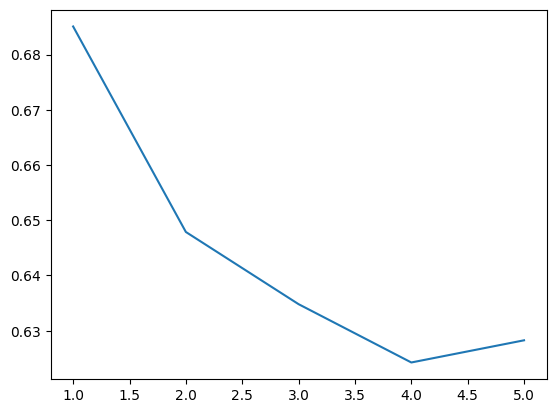

In [5]:
import logging
import os
import sys
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_image_paths_and_labels(data_dir, labels_csv):
    """
    Load image paths and corresponding labels from the directory and CSV file.

    Args:
    - data_dir (str): Directory containing the image files.
    - labels_csv (str): Path to the CSV file containing labels.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    # Read labels CSV
    labels_df = pd.read_csv(labels_csv)

    image_paths = []
    labels = []

    for _, row in labels_df.iterrows():
        patient_id = row['PatientID']
        label = row['Cancer']
        # Find all image files for the patient
        patient_images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith(patient_id)]
        image_paths.extend(patient_images)
        labels.extend([label] * len(patient_images))

    return image_paths, labels

def plot_and_save_metrics(epochs, train_metrics, val_metrics, metric_name, save_path):
    plt.figure()
    plt.plot(epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Train and Validation {metric_name}')
    plt.savefig(os.path.join(save_path, f'{metric_name}.png'))

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    data_dir = '/content/drive/MyDrive/Praktikum/3d_dataset_2/3d_patches_nii/'  # Directory containing the image files
    labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(data_dir, labels_csv)
    labels = np.array(labels, dtype=np.int64)

    # Debugging: Print number of images and labels
    print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    print(f"Labels distribution: {np.bincount(labels)}")

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])

    # Split dataset into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Debugging: Print train and validation label distributions
    print(f"Train labels distribution: {np.bincount(train_labels)}")
    print(f"Validation labels distribution: {np.bincount(val_labels)}")

    # Create datasets and dataloaders
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

    # Create DenseNet121, CrossEntropyLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)

    val_interval = 2
    best_metric = -1
    epoch_loss_values = list()
    epoch_accuracy_values = list()
    epoch_recall_values = list()
    epoch_auc_values = list()
    epoch_f1_values = list()
    epoch_mcc_values = list()
    writer = SummaryWriter()

    for epoch in range(5):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{5}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                num_correct = 0.0
                metric_count = 0
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                    val_true.extend(val_labels.cpu().numpy())
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()
            accuracy = accuracy_score(val_true, val_preds)
            recall = recall_score(val_true, val_preds)
            auc = roc_auc_score(val_true, val_preds)
            f1 = f1_score(val_true, val_preds)
            mcc = matthews_corrcoef(val_true, val_preds)

            epoch_accuracy_values.append(accuracy)
            epoch_recall_values.append(recall)
            epoch_auc_values.append(auc)
            epoch_f1_values.append(f1)
            epoch_mcc_values.append(mcc)

            if accuracy > best_metric:
                best_metric = accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy:.4f} best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", accuracy, epoch + 1)

    # Save metrics as PNG
    metrics = {
        'accuracy': epoch_accuracy_values,
        'recall': epoch_recall_values,
        'auc': epoch_auc_values,
        'f1': epoch_f1_values,
        'mcc': epoch_mcc_values
    }
    for metric_name, metric_values in metrics.items():
        plot_and_save_metrics(list(range(1, 6)), epoch_loss_values, metric_values, metric_name, '/content/')

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()


#ResNext50

MONAI version: 1.3.1
Numpy version: 1.25.2
Pytorch version: 2.3.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 10.3.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cpu
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    ht

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.7054
2/168, train_loss: 0.7182
3/168, train_loss: 0.8881
4/168, train_loss: 0.6956
5/168, train_loss: 0.6929
6/168, train_loss: 0.7401
7/168, train_loss: 0.5131
8/168, train_loss: 0.7248
9/168, train_loss: 0.8122
10/168, train_loss: 0.7185
11/168, train_loss: 0.6764
12/168, train_loss: 0.8342
13/168, train_loss: 0.3584
14/168, train_loss: 0.7054
15/168, train_loss: 1.6734
16/168, train_loss: 0.6311
17/168, train_loss: 0.2255
18/168, train_loss: 0.3089
19/168, train_loss: 0.6935
20/168, train_loss: 0.9154
21/168, train_loss: 1.2989
22/168, train_loss: 0.6521
23/168, train_loss: 0.7883
24/168, train_loss: 0.3293
25/168, train_loss: 0.7019
26/168, train_loss: 0.7290
27/168, train_loss: 0.7897
28/168, train_loss: 0.7243
29/168, train_loss: 0.6939
30/168, train_loss: 0.6707
31/168, train_loss: 0.5109
32/168, train_loss: 0.8829
33/168, train_loss: 0.6907
34/168, train_loss: 0.5907
35/168, train_loss: 0.7202
36/168, train_loss: 0.6678
37/168, train_loss: 0.6915
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4840
2/168, train_loss: 0.4825
3/168, train_loss: 0.4628
4/168, train_loss: 0.4017
5/168, train_loss: 0.4266
6/168, train_loss: 0.3547
7/168, train_loss: 0.4992
8/168, train_loss: 1.5144
9/168, train_loss: 0.7932
10/168, train_loss: 0.8164
11/168, train_loss: 0.8891
12/168, train_loss: 0.6942
13/168, train_loss: 0.9788
14/168, train_loss: 0.5128
15/168, train_loss: 1.3139
16/168, train_loss: 1.1469
17/168, train_loss: 0.7190
18/168, train_loss: 0.4743
19/168, train_loss: 0.7497
20/168, train_loss: 1.0286
21/168, train_loss: 0.5519
22/168, train_loss: 0.4614
23/168, train_loss: 0.4938
24/168, train_loss: 0.9721
25/168, train_loss: 0.3673
26/168, train_loss: 0.5620
27/168, train_loss: 0.5385
28/168, train_loss: 0.6391
29/168, train_loss: 0.9850
30/168, train_loss: 0.9410
31/168, train_loss: 0.9378
32/168, train_loss: 0.4953
33/168, train_loss: 0.4986
34/168, train_loss: 0.7092
35/168, train_loss: 0.4246
36/168, train_loss: 0.4862
37/168, train_loss: 0.9292
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.1726
2/168, train_loss: 0.2958
3/168, train_loss: 0.4195
4/168, train_loss: 0.8138
5/168, train_loss: 1.0870
6/168, train_loss: 0.4793
7/168, train_loss: 0.5539
8/168, train_loss: 0.4575
9/168, train_loss: 0.4281
10/168, train_loss: 0.5743
11/168, train_loss: 0.7275
12/168, train_loss: 0.3060
13/168, train_loss: 0.4236
14/168, train_loss: 0.4560
15/168, train_loss: 0.4455
16/168, train_loss: 0.7256
17/168, train_loss: 0.4458
18/168, train_loss: 0.3045
19/168, train_loss: 0.2903
20/168, train_loss: 0.9715
21/168, train_loss: 0.5390
22/168, train_loss: 1.1899
23/168, train_loss: 0.7143
24/168, train_loss: 0.4304
25/168, train_loss: 0.4427
26/168, train_loss: 0.9901
27/168, train_loss: 1.0061
28/168, train_loss: 0.6291
29/168, train_loss: 0.6088
30/168, train_loss: 0.2026
31/168, train_loss: 0.5273
32/168, train_loss: 0.2511
33/168, train_loss: 0.5958
34/168, train_loss: 0.8843
35/168, train_loss: 0.3224
36/168, train_loss: 0.7894
37/168, train_loss: 0.4492
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4194
2/168, train_loss: 0.1786
3/168, train_loss: 0.3738
4/168, train_loss: 1.0171
5/168, train_loss: 0.4539
6/168, train_loss: 1.0966
7/168, train_loss: 0.4761
8/168, train_loss: 0.4040
9/168, train_loss: 1.1102
10/168, train_loss: 0.5392
11/168, train_loss: 0.4152
12/168, train_loss: 0.6062
13/168, train_loss: 1.0478
14/168, train_loss: 0.4975
15/168, train_loss: 0.7424
16/168, train_loss: 0.4263
17/168, train_loss: 0.6550
18/168, train_loss: 0.8953
19/168, train_loss: 0.3480
20/168, train_loss: 0.9211
21/168, train_loss: 1.0865
22/168, train_loss: 0.4806
23/168, train_loss: 0.1107
24/168, train_loss: 0.5368
25/168, train_loss: 1.0114
26/168, train_loss: 0.4840
27/168, train_loss: 0.5071
28/168, train_loss: 0.7249
29/168, train_loss: 0.4422
30/168, train_loss: 0.4617
31/168, train_loss: 0.9551
32/168, train_loss: 0.5382
33/168, train_loss: 0.4244
34/168, train_loss: 0.4610
35/168, train_loss: 0.1356
36/168, train_loss: 0.5256
37/168, train_loss: 0.1609
38/168, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/168, train_loss: 0.4313
2/168, train_loss: 0.4506
3/168, train_loss: 0.2256
4/168, train_loss: 0.4232
5/168, train_loss: 0.5552
6/168, train_loss: 0.3971
7/168, train_loss: 0.5241
8/168, train_loss: 0.4060
9/168, train_loss: 0.7089
10/168, train_loss: 0.8875
11/168, train_loss: 0.4643
12/168, train_loss: 0.5480
13/168, train_loss: 0.1824
14/168, train_loss: 0.5496
15/168, train_loss: 0.4014
16/168, train_loss: 0.3957
17/168, train_loss: 0.7076
18/168, train_loss: 0.3844
19/168, train_loss: 1.0748
20/168, train_loss: 0.3924
21/168, train_loss: 0.7728
22/168, train_loss: 1.0687
23/168, train_loss: 0.5784
24/168, train_loss: 0.4415
25/168, train_loss: 0.4375
26/168, train_loss: 0.8904
27/168, train_loss: 0.4492
28/168, train_loss: 0.5042
29/168, train_loss: 0.2214
30/168, train_loss: 0.2943
31/168, train_loss: 0.4166
32/168, train_loss: 1.0611
33/168, train_loss: 0.7041
34/168, train_loss: 0.8650
35/168, train_loss: 0.3621
36/168, train_loss: 1.1308
37/168, train_loss: 0.4047
38/168, tr

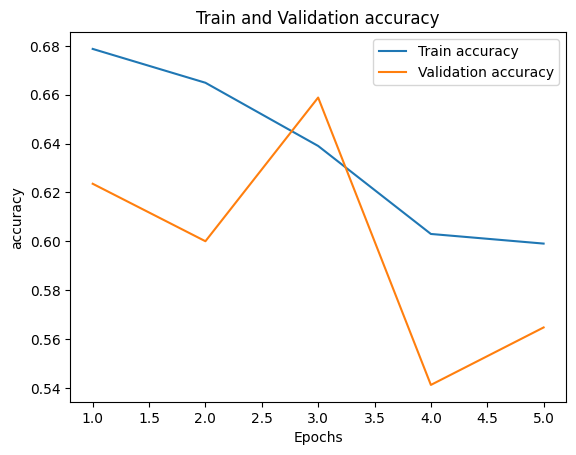

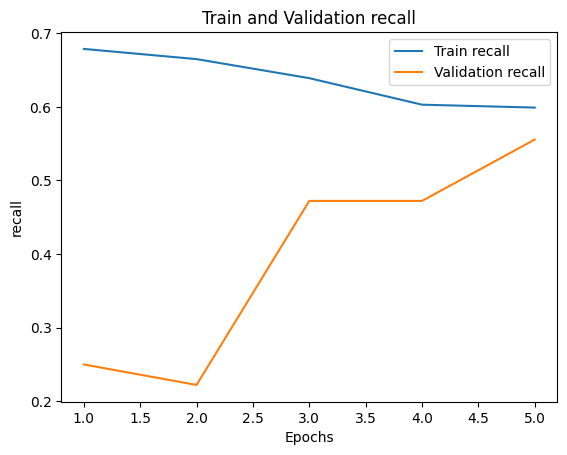

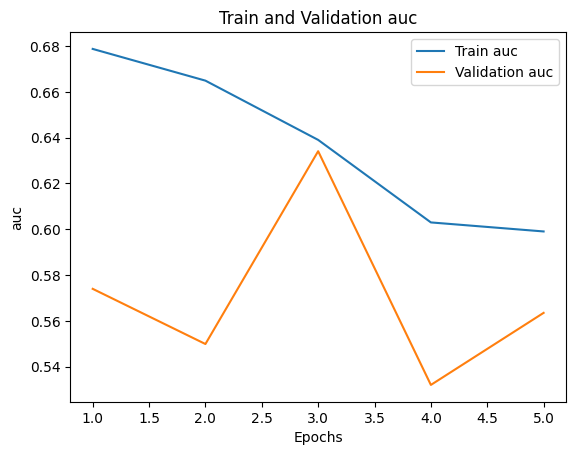

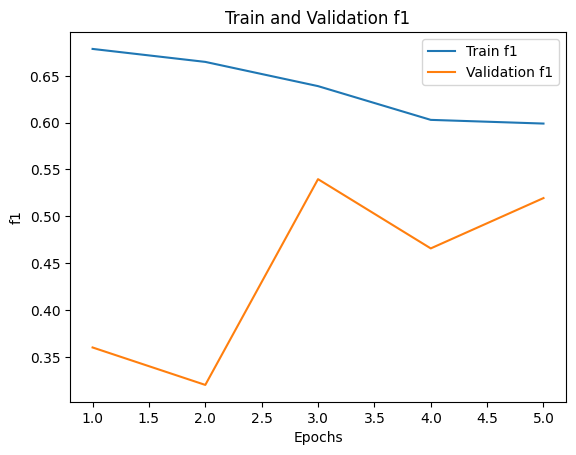

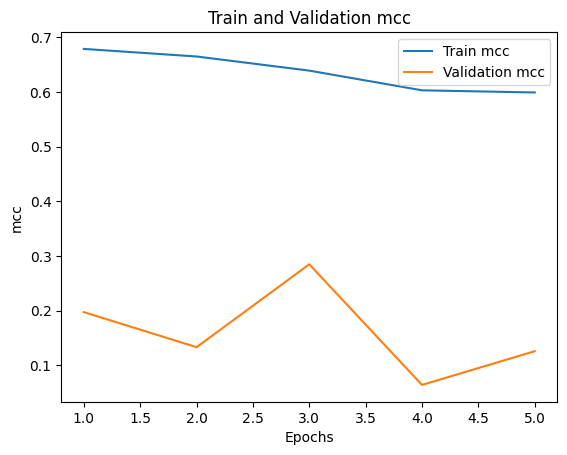

In [10]:
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity, RepeatChannel
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models.video import r3d_18

def load_image_paths_and_labels(data_dir, labels_csv):
    """
    Load image paths and corresponding labels from the directory and CSV file.

    Args:
    - data_dir (str): Directory containing the image files.
    - labels_csv (str): Path to the CSV file containing labels.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    # Read labels CSV
    labels_df = pd.read_csv(labels_csv)

    image_paths = []
    labels = []

    for _, row in labels_df.iterrows():
        patient_id = row['PatientID']
        label = row['Cancer']
        # Find all image files for the patient
        patient_images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith(patient_id)]
        image_paths.extend(patient_images)
        labels.extend([label] * len(patient_images))

    return image_paths, labels

def plot_and_save_metrics(epochs, train_metrics, val_metrics, metric_name, save_path):
    plt.figure()
    plt.plot(epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Train and Validation {metric_name}')
    plt.savefig(os.path.join(save_path, f'{metric_name}.png'))

class ResNeXt3D(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNeXt3D, self).__init__()
        self.model = r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    data_dir = '/content/drive/MyDrive/Praktikum/3d_dataset_2/3d_patches_nii/'  # Directory containing the image files
    labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

    # Number of epochs
    num_epochs = 10  # Change this value to set the number of epochs

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(data_dir, labels_csv)
    labels = np.array(labels, dtype=np.int64)

    # Debugging: Print number of images and labels
    print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    print(f"Labels distribution: {np.bincount(labels)}")

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96))])

    # Split dataset into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Debugging: Print train and validation label distributions
    print(f"Train labels distribution: {np.bincount(train_labels)}")
    print(f"Validation labels distribution: {np.bincount(val_labels)}")

    # Create datasets and dataloaders
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

    # Create ResNeXt50 3D, CrossEntropyLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNeXt3D(num_classes=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    epoch_accuracy_values = list()
    epoch_recall_values = list()
    epoch_auc_values = list()
    epoch_f1_values = list()
    epoch_mcc_values = list()
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                num_correct = 0.0
                metric_count = 0
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                    val_true.extend(val_labels.cpu().numpy())
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()
            accuracy = accuracy_score(val_true, val_preds)
            recall = recall_score(val_true, val_preds)
            auc = roc_auc_score(val_true, val_preds)
            f1 = f1_score(val_true, val_preds)
            mcc = matthews_corrcoef(val_true, val_preds)

            epoch_accuracy_values.append(accuracy)
            epoch_recall_values.append(recall)
            epoch_auc_values.append(auc)
            epoch_f1_values.append(f1)
            epoch_mcc_values.append(mcc)

            if accuracy > best_metric:
                best_metric = accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_5E_RNext50.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy:.4f} best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", accuracy, epoch + 1)

    # Save metrics as PNG
    epochs = list(range(1, num_epochs + 1))
    metrics = {
        'accuracy': epoch_accuracy_values,
        'recall': epoch_recall_values,
        'auc': epoch_auc_values,
        'f1': epoch_f1_values,
        'mcc': epoch_mcc_values
    }
    for metric_name, metric_values in metrics.items():
        plot_and_save_metrics(epochs[:len(metric_values)], epoch_loss_values[:len(metric_values)], metric_values, metric_name, '/content/')

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()
